# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

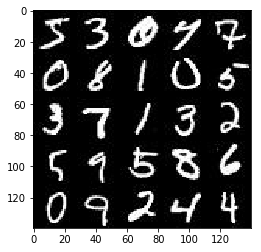

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

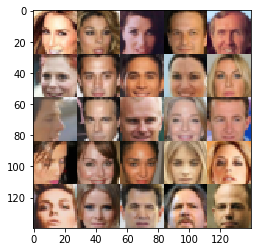

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

c:\users\florian\anaconda3\envs\dlnd\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    tf_inputs = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='inputs')

    tf_z_data = tf.placeholder(tf.float32, [None, z_dim], name='z_data')

    lr = tf.placeholder(tf.float32, name='lr')
    
    return (tf_inputs, tf_z_data, lr)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
#add dropout?
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
            # Input layer is 32x32x3
            x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
            relu1 = tf.maximum(alpha * x1, x1)
            # 16x16x64

            x2 = tf.layers.conv2d(relu1, 124, 5, strides=2, padding='same')
            bn2 = tf.layers.batch_normalization(x2, training=True)
            relu2 = tf.maximum(alpha * bn2, bn2)
            # 8x8x128
            
            x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
            bn3 = tf.layers.batch_normalization(x3, training=True)
            relu3 = tf.maximum(alpha * bn3, bn3)
            # 4x4x256

            # Flatten it
            flat = tf.reshape(relu3, (-1, 2*2*256))
            logits = tf.layers.dense(flat, 1)
            out = tf.sigmoid(logits)

            return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
#dropout?
#check use of reuse variable
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    #reuse=False
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 32x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    generator_model = generator(input_z, out_channel_dim)
    discriminator_model_real, discriminator_logits_real = discriminator(input_real)
    discriminator_model_fake, discriminator_logits_fake = discriminator(generator_model, reuse=True)

    discriminator_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_real, labels=tf.ones_like(discriminator_model_real)))
    discriminator_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.zeros_like(discriminator_model_fake)))
    generator_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.ones_like(discriminator_model_fake)))

    discriminator_loss = discriminator_loss_real + discriminator_loss_fake

    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(discriminator_loss, generator_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    discriminator_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    generator_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        discriminator_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(discriminator_loss, var_list=discriminator_vars)
        generator_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(generator_loss, var_list=generator_vars)

    return discriminator_train_opt, generator_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    samples, losses = [], []
    steps = 0
    
    print_every=10
    show_every=100
    
    
    #if (data_image_mode == "L"):
    #    out_channel_dim=1
    #else:
    #    out_channel_dim=3
    
    #tf.reset_default_graph()
    # model_inputs(image_width, image_height, image_channels, z_dim)
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    discriminator_loss, generator_loss = model_loss(input_real, input_z, data_shape[3])
    discriminator_opt, generator_opt = model_opt(discriminator_loss, generator_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps += 1

                batch_images = batch_images * 2
               
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                
                _ = sess.run(discriminator_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(generator_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_discriminator = discriminator_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_generator = generator_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_discriminator),
                          "Generator Loss: {:.4f}".format(train_loss_generator),
                          "Total Loss: {:.4f}".format(train_loss_generator+train_loss_discriminator))
                    
                    # Save losses to view after training
                    losses.append((train_loss_discriminator, train_loss_generator))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
            
            #show at end of epoch
            show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
            
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 2.6520... Generator Loss: 0.1726
Epoch 1/2... Batch 20... Discriminator Loss: 0.1695... Generator Loss: 6.1134
Epoch 1/2... Batch 30... Discriminator Loss: 0.6383... Generator Loss: 2.8875
Epoch 1/2... Batch 40... Discriminator Loss: 0.2742... Generator Loss: 2.8162
Epoch 1/2... Batch 50... Discriminator Loss: 0.5532... Generator Loss: 1.7017
Epoch 1/2... Batch 60... Discriminator Loss: 0.2573... Generator Loss: 4.7312
Epoch 1/2... Batch 70... Discriminator Loss: 0.9863... Generator Loss: 0.8701
Epoch 1/2... Batch 80... Discriminator Loss: 0.1973... Generator Loss: 2.8933
Epoch 1/2... Batch 90... Discriminator Loss: 0.4024... Generator Loss: 1.8022
Epoch 1/2... Batch 100... Discriminator Loss: 0.4046... Generator Loss: 2.0793


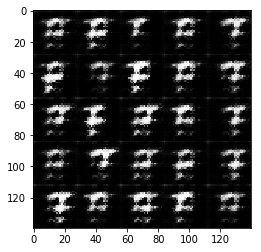

Epoch 1/2... Batch 110... Discriminator Loss: 0.5404... Generator Loss: 3.2424
Epoch 1/2... Batch 120... Discriminator Loss: 0.5109... Generator Loss: 2.1633
Epoch 1/2... Batch 130... Discriminator Loss: 0.6089... Generator Loss: 1.3802
Epoch 1/2... Batch 140... Discriminator Loss: 1.6384... Generator Loss: 0.3405
Epoch 1/2... Batch 150... Discriminator Loss: 0.4721... Generator Loss: 3.3452
Epoch 1/2... Batch 160... Discriminator Loss: 1.4800... Generator Loss: 0.4414
Epoch 1/2... Batch 170... Discriminator Loss: 0.8407... Generator Loss: 1.6290
Epoch 1/2... Batch 180... Discriminator Loss: 0.8870... Generator Loss: 5.8767
Epoch 1/2... Batch 190... Discriminator Loss: 1.7798... Generator Loss: 0.3948
Epoch 1/2... Batch 200... Discriminator Loss: 0.6823... Generator Loss: 2.5898


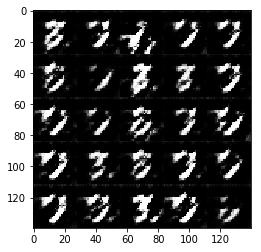

Epoch 1/2... Batch 210... Discriminator Loss: 0.2247... Generator Loss: 2.5922
Epoch 1/2... Batch 220... Discriminator Loss: 0.5576... Generator Loss: 1.7134
Epoch 1/2... Batch 230... Discriminator Loss: 0.3960... Generator Loss: 1.8425
Epoch 1/2... Batch 240... Discriminator Loss: 0.5907... Generator Loss: 4.1349
Epoch 1/2... Batch 250... Discriminator Loss: 0.1957... Generator Loss: 4.0866
Epoch 1/2... Batch 260... Discriminator Loss: 0.7371... Generator Loss: 4.1525
Epoch 1/2... Batch 270... Discriminator Loss: 0.2919... Generator Loss: 2.4375
Epoch 1/2... Batch 280... Discriminator Loss: 1.6570... Generator Loss: 0.3583
Epoch 1/2... Batch 290... Discriminator Loss: 0.6030... Generator Loss: 1.3391
Epoch 1/2... Batch 300... Discriminator Loss: 1.7417... Generator Loss: 7.5476


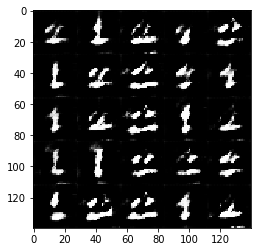

Epoch 1/2... Batch 310... Discriminator Loss: 0.2601... Generator Loss: 2.4974
Epoch 1/2... Batch 320... Discriminator Loss: 1.7663... Generator Loss: 7.5170
Epoch 1/2... Batch 330... Discriminator Loss: 0.2932... Generator Loss: 2.7166
Epoch 1/2... Batch 340... Discriminator Loss: 0.2892... Generator Loss: 2.6010
Epoch 1/2... Batch 350... Discriminator Loss: 0.4369... Generator Loss: 1.8454
Epoch 1/2... Batch 360... Discriminator Loss: 0.6548... Generator Loss: 1.3929
Epoch 1/2... Batch 370... Discriminator Loss: 0.4434... Generator Loss: 1.8046
Epoch 1/2... Batch 380... Discriminator Loss: 0.6613... Generator Loss: 1.0618
Epoch 1/2... Batch 390... Discriminator Loss: 1.1390... Generator Loss: 3.8452
Epoch 1/2... Batch 400... Discriminator Loss: 0.6507... Generator Loss: 1.3814


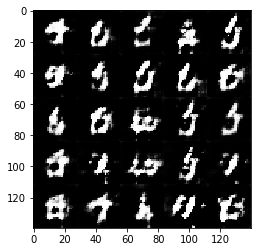

Epoch 1/2... Batch 410... Discriminator Loss: 0.4875... Generator Loss: 3.0371
Epoch 1/2... Batch 420... Discriminator Loss: 0.3287... Generator Loss: 2.0314
Epoch 1/2... Batch 430... Discriminator Loss: 0.3715... Generator Loss: 2.4672
Epoch 1/2... Batch 440... Discriminator Loss: 0.4837... Generator Loss: 1.5152
Epoch 1/2... Batch 450... Discriminator Loss: 0.2748... Generator Loss: 2.6792
Epoch 1/2... Batch 460... Discriminator Loss: 0.8995... Generator Loss: 3.8797
Epoch 1/2... Batch 470... Discriminator Loss: 0.6624... Generator Loss: 1.4678
Epoch 1/2... Batch 480... Discriminator Loss: 0.4424... Generator Loss: 1.6891
Epoch 1/2... Batch 490... Discriminator Loss: 0.3835... Generator Loss: 2.0391
Epoch 1/2... Batch 500... Discriminator Loss: 0.3941... Generator Loss: 2.1440


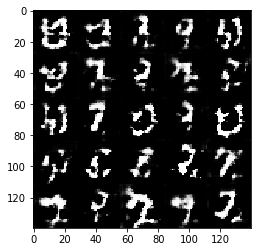

Epoch 1/2... Batch 510... Discriminator Loss: 0.5593... Generator Loss: 2.1547
Epoch 1/2... Batch 520... Discriminator Loss: 0.8267... Generator Loss: 1.0435
Epoch 1/2... Batch 530... Discriminator Loss: 0.7536... Generator Loss: 3.4775
Epoch 1/2... Batch 540... Discriminator Loss: 0.5753... Generator Loss: 1.2342
Epoch 1/2... Batch 550... Discriminator Loss: 0.4394... Generator Loss: 1.9123
Epoch 1/2... Batch 560... Discriminator Loss: 0.5499... Generator Loss: 2.4468
Epoch 1/2... Batch 570... Discriminator Loss: 0.8384... Generator Loss: 0.9541
Epoch 1/2... Batch 580... Discriminator Loss: 1.6220... Generator Loss: 5.1353
Epoch 1/2... Batch 590... Discriminator Loss: 0.5781... Generator Loss: 1.5921
Epoch 1/2... Batch 600... Discriminator Loss: 2.0376... Generator Loss: 5.3076


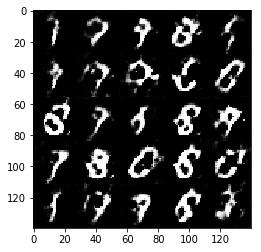

Epoch 1/2... Batch 610... Discriminator Loss: 0.7115... Generator Loss: 1.1939
Epoch 1/2... Batch 620... Discriminator Loss: 0.6226... Generator Loss: 1.6652
Epoch 1/2... Batch 630... Discriminator Loss: 0.7125... Generator Loss: 1.5184
Epoch 1/2... Batch 640... Discriminator Loss: 0.7875... Generator Loss: 4.0322
Epoch 1/2... Batch 650... Discriminator Loss: 1.1480... Generator Loss: 0.8307
Epoch 1/2... Batch 660... Discriminator Loss: 0.5248... Generator Loss: 1.6456
Epoch 1/2... Batch 670... Discriminator Loss: 0.5292... Generator Loss: 2.0183
Epoch 1/2... Batch 680... Discriminator Loss: 1.0015... Generator Loss: 0.7117
Epoch 1/2... Batch 690... Discriminator Loss: 0.4967... Generator Loss: 1.9915
Epoch 1/2... Batch 700... Discriminator Loss: 1.0971... Generator Loss: 3.4651


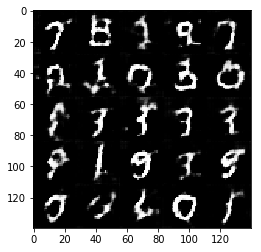

Epoch 1/2... Batch 710... Discriminator Loss: 0.9768... Generator Loss: 0.9542
Epoch 1/2... Batch 720... Discriminator Loss: 0.7401... Generator Loss: 1.1126
Epoch 1/2... Batch 730... Discriminator Loss: 0.8518... Generator Loss: 1.0519
Epoch 1/2... Batch 740... Discriminator Loss: 0.5886... Generator Loss: 2.3463
Epoch 1/2... Batch 750... Discriminator Loss: 1.1561... Generator Loss: 0.7278
Epoch 1/2... Batch 760... Discriminator Loss: 0.7061... Generator Loss: 1.4431
Epoch 1/2... Batch 770... Discriminator Loss: 0.5743... Generator Loss: 2.5027
Epoch 1/2... Batch 780... Discriminator Loss: 0.9002... Generator Loss: 1.2350
Epoch 1/2... Batch 790... Discriminator Loss: 0.8482... Generator Loss: 1.6439
Epoch 1/2... Batch 800... Discriminator Loss: 0.6458... Generator Loss: 1.5044


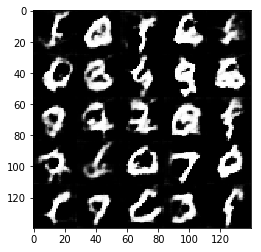

Epoch 1/2... Batch 810... Discriminator Loss: 0.5673... Generator Loss: 2.0899
Epoch 1/2... Batch 820... Discriminator Loss: 0.6779... Generator Loss: 2.2650
Epoch 1/2... Batch 830... Discriminator Loss: 0.8033... Generator Loss: 1.5507
Epoch 1/2... Batch 840... Discriminator Loss: 0.6734... Generator Loss: 1.8020
Epoch 1/2... Batch 850... Discriminator Loss: 0.7773... Generator Loss: 1.0358
Epoch 1/2... Batch 860... Discriminator Loss: 1.4425... Generator Loss: 0.6134
Epoch 1/2... Batch 870... Discriminator Loss: 1.0305... Generator Loss: 1.6363
Epoch 1/2... Batch 880... Discriminator Loss: 0.5794... Generator Loss: 1.4919
Epoch 1/2... Batch 890... Discriminator Loss: 0.7511... Generator Loss: 1.1457
Epoch 1/2... Batch 900... Discriminator Loss: 0.7929... Generator Loss: 1.0010


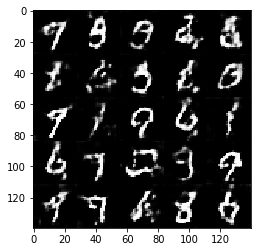

Epoch 1/2... Batch 910... Discriminator Loss: 0.8903... Generator Loss: 0.8690
Epoch 1/2... Batch 920... Discriminator Loss: 0.6619... Generator Loss: 1.2212
Epoch 1/2... Batch 930... Discriminator Loss: 0.6197... Generator Loss: 1.6386


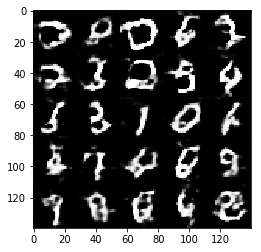

Epoch 2/2... Batch 10... Discriminator Loss: 0.6940... Generator Loss: 1.6260
Epoch 2/2... Batch 20... Discriminator Loss: 0.8077... Generator Loss: 0.9039
Epoch 2/2... Batch 30... Discriminator Loss: 0.9675... Generator Loss: 0.8169
Epoch 2/2... Batch 40... Discriminator Loss: 1.0976... Generator Loss: 2.2607
Epoch 2/2... Batch 50... Discriminator Loss: 0.7028... Generator Loss: 1.5204
Epoch 2/2... Batch 60... Discriminator Loss: 0.8831... Generator Loss: 0.8671
Epoch 2/2... Batch 70... Discriminator Loss: 0.7254... Generator Loss: 1.2328
Epoch 2/2... Batch 80... Discriminator Loss: 0.6783... Generator Loss: 1.1207
Epoch 2/2... Batch 90... Discriminator Loss: 0.8751... Generator Loss: 2.1370
Epoch 2/2... Batch 100... Discriminator Loss: 0.9445... Generator Loss: 0.8352


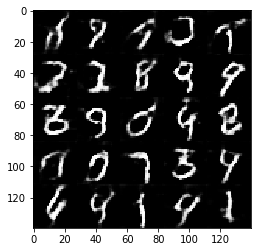

Epoch 2/2... Batch 110... Discriminator Loss: 0.9772... Generator Loss: 0.8365
Epoch 2/2... Batch 120... Discriminator Loss: 0.7538... Generator Loss: 1.2277
Epoch 2/2... Batch 130... Discriminator Loss: 0.7461... Generator Loss: 1.6027
Epoch 2/2... Batch 140... Discriminator Loss: 1.0829... Generator Loss: 2.2510
Epoch 2/2... Batch 150... Discriminator Loss: 0.7710... Generator Loss: 1.2813
Epoch 2/2... Batch 160... Discriminator Loss: 0.8042... Generator Loss: 1.1647
Epoch 2/2... Batch 170... Discriminator Loss: 1.0975... Generator Loss: 0.9497
Epoch 2/2... Batch 180... Discriminator Loss: 0.9446... Generator Loss: 0.8795
Epoch 2/2... Batch 190... Discriminator Loss: 0.7102... Generator Loss: 1.2590
Epoch 2/2... Batch 200... Discriminator Loss: 1.3752... Generator Loss: 2.8033


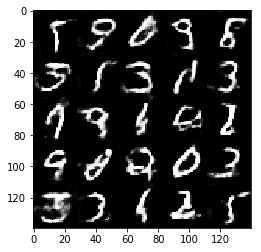

Epoch 2/2... Batch 210... Discriminator Loss: 0.6903... Generator Loss: 1.2587
Epoch 2/2... Batch 220... Discriminator Loss: 0.7914... Generator Loss: 0.9827
Epoch 2/2... Batch 230... Discriminator Loss: 1.0724... Generator Loss: 0.8645
Epoch 2/2... Batch 240... Discriminator Loss: 0.9971... Generator Loss: 1.0616
Epoch 2/2... Batch 250... Discriminator Loss: 0.6487... Generator Loss: 1.0737
Epoch 2/2... Batch 260... Discriminator Loss: 0.6975... Generator Loss: 1.7523
Epoch 2/2... Batch 270... Discriminator Loss: 0.8149... Generator Loss: 1.2013
Epoch 2/2... Batch 280... Discriminator Loss: 1.2883... Generator Loss: 1.5129
Epoch 2/2... Batch 290... Discriminator Loss: 0.8907... Generator Loss: 0.8278
Epoch 2/2... Batch 300... Discriminator Loss: 1.3395... Generator Loss: 0.4457


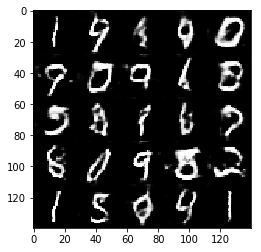

Epoch 2/2... Batch 310... Discriminator Loss: 1.0320... Generator Loss: 1.1135
Epoch 2/2... Batch 320... Discriminator Loss: 0.8047... Generator Loss: 1.0989
Epoch 2/2... Batch 330... Discriminator Loss: 0.6184... Generator Loss: 1.8162
Epoch 2/2... Batch 340... Discriminator Loss: 2.1984... Generator Loss: 2.3051
Epoch 2/2... Batch 350... Discriminator Loss: 0.9992... Generator Loss: 1.5991
Epoch 2/2... Batch 360... Discriminator Loss: 0.5982... Generator Loss: 1.4771
Epoch 2/2... Batch 370... Discriminator Loss: 0.7560... Generator Loss: 1.1007
Epoch 2/2... Batch 380... Discriminator Loss: 2.1835... Generator Loss: 3.5944
Epoch 2/2... Batch 390... Discriminator Loss: 1.9182... Generator Loss: 3.3301
Epoch 2/2... Batch 400... Discriminator Loss: 0.9353... Generator Loss: 0.8087


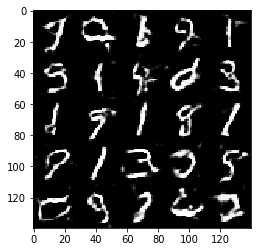

Epoch 2/2... Batch 410... Discriminator Loss: 0.7002... Generator Loss: 1.7089
Epoch 2/2... Batch 420... Discriminator Loss: 0.7438... Generator Loss: 1.2005
Epoch 2/2... Batch 430... Discriminator Loss: 1.0297... Generator Loss: 0.8004
Epoch 2/2... Batch 440... Discriminator Loss: 0.7693... Generator Loss: 1.4070
Epoch 2/2... Batch 450... Discriminator Loss: 0.7900... Generator Loss: 1.3237
Epoch 2/2... Batch 460... Discriminator Loss: 0.8883... Generator Loss: 0.7105
Epoch 2/2... Batch 470... Discriminator Loss: 0.9548... Generator Loss: 0.7453
Epoch 2/2... Batch 480... Discriminator Loss: 0.7515... Generator Loss: 1.0680
Epoch 2/2... Batch 490... Discriminator Loss: 0.9563... Generator Loss: 0.7159
Epoch 2/2... Batch 500... Discriminator Loss: 0.9980... Generator Loss: 0.7225


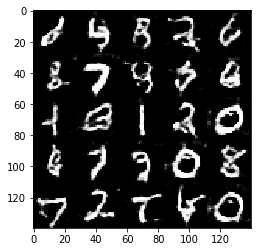

Epoch 2/2... Batch 510... Discriminator Loss: 1.7015... Generator Loss: 0.3560
Epoch 2/2... Batch 520... Discriminator Loss: 1.0787... Generator Loss: 0.8992
Epoch 2/2... Batch 530... Discriminator Loss: 1.1193... Generator Loss: 1.2398
Epoch 2/2... Batch 540... Discriminator Loss: 1.0076... Generator Loss: 0.7234
Epoch 2/2... Batch 550... Discriminator Loss: 0.8305... Generator Loss: 1.4495
Epoch 2/2... Batch 560... Discriminator Loss: 0.8419... Generator Loss: 0.9840
Epoch 2/2... Batch 570... Discriminator Loss: 1.0582... Generator Loss: 0.6806
Epoch 2/2... Batch 580... Discriminator Loss: 0.9850... Generator Loss: 0.6940
Epoch 2/2... Batch 590... Discriminator Loss: 0.8214... Generator Loss: 1.1667
Epoch 2/2... Batch 600... Discriminator Loss: 1.1059... Generator Loss: 1.3074


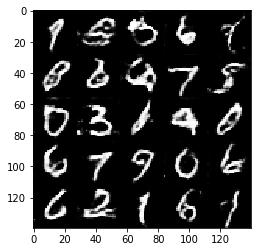

Epoch 2/2... Batch 610... Discriminator Loss: 0.9290... Generator Loss: 0.8325
Epoch 2/2... Batch 620... Discriminator Loss: 0.9561... Generator Loss: 1.4155
Epoch 2/2... Batch 630... Discriminator Loss: 0.9643... Generator Loss: 0.7606
Epoch 2/2... Batch 640... Discriminator Loss: 0.9326... Generator Loss: 0.7414
Epoch 2/2... Batch 650... Discriminator Loss: 1.4843... Generator Loss: 0.8610
Epoch 2/2... Batch 660... Discriminator Loss: 1.1440... Generator Loss: 0.6291
Epoch 2/2... Batch 670... Discriminator Loss: 1.0045... Generator Loss: 0.8476
Epoch 2/2... Batch 680... Discriminator Loss: 1.0674... Generator Loss: 1.3121
Epoch 2/2... Batch 690... Discriminator Loss: 1.0048... Generator Loss: 0.6459
Epoch 2/2... Batch 700... Discriminator Loss: 1.0680... Generator Loss: 0.7258


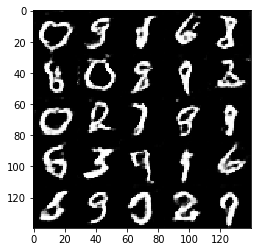

Epoch 2/2... Batch 710... Discriminator Loss: 1.0739... Generator Loss: 0.6913
Epoch 2/2... Batch 720... Discriminator Loss: 1.2037... Generator Loss: 0.5166
Epoch 2/2... Batch 730... Discriminator Loss: 0.8411... Generator Loss: 1.2257
Epoch 2/2... Batch 740... Discriminator Loss: 0.8821... Generator Loss: 1.1260
Epoch 2/2... Batch 750... Discriminator Loss: 1.0664... Generator Loss: 0.7364
Epoch 2/2... Batch 760... Discriminator Loss: 0.7487... Generator Loss: 1.1257
Epoch 2/2... Batch 770... Discriminator Loss: 1.3300... Generator Loss: 0.4356
Epoch 2/2... Batch 780... Discriminator Loss: 0.9671... Generator Loss: 0.8653
Epoch 2/2... Batch 790... Discriminator Loss: 1.0390... Generator Loss: 0.6975
Epoch 2/2... Batch 800... Discriminator Loss: 1.2662... Generator Loss: 0.5899


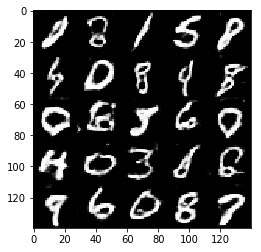

Epoch 2/2... Batch 810... Discriminator Loss: 1.0297... Generator Loss: 0.9083
Epoch 2/2... Batch 820... Discriminator Loss: 0.8899... Generator Loss: 0.9235
Epoch 2/2... Batch 830... Discriminator Loss: 1.1317... Generator Loss: 0.5764
Epoch 2/2... Batch 840... Discriminator Loss: 0.7865... Generator Loss: 2.3619
Epoch 2/2... Batch 850... Discriminator Loss: 1.0349... Generator Loss: 0.6082
Epoch 2/2... Batch 860... Discriminator Loss: 1.6061... Generator Loss: 1.5476
Epoch 2/2... Batch 870... Discriminator Loss: 1.2652... Generator Loss: 0.7620
Epoch 2/2... Batch 880... Discriminator Loss: 1.0135... Generator Loss: 1.4372
Epoch 2/2... Batch 890... Discriminator Loss: 0.9621... Generator Loss: 0.7587
Epoch 2/2... Batch 900... Discriminator Loss: 1.1308... Generator Loss: 0.5659


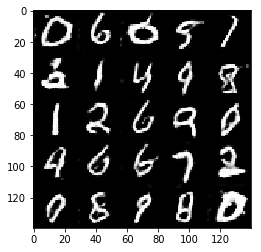

Epoch 2/2... Batch 910... Discriminator Loss: 0.9473... Generator Loss: 0.7691
Epoch 2/2... Batch 920... Discriminator Loss: 0.9117... Generator Loss: 0.8087
Epoch 2/2... Batch 930... Discriminator Loss: 1.0955... Generator Loss: 0.5883


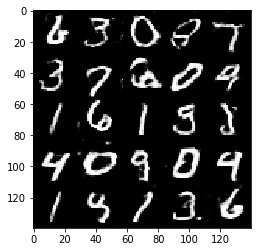

In [40]:
batch_size = 64
z_dim = 100
lr = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, lr, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Batch 10... Discriminator Loss: 0.0362... Generator Loss: 8.3168
Epoch 1/2... Batch 20... Discriminator Loss: 0.8598... Generator Loss: 2.5454
Epoch 1/2... Batch 30... Discriminator Loss: 0.1724... Generator Loss: 2.3977
Epoch 1/2... Batch 40... Discriminator Loss: 0.0763... Generator Loss: 5.9962
Epoch 1/2... Batch 50... Discriminator Loss: 0.2880... Generator Loss: 1.7834
Epoch 1/2... Batch 60... Discriminator Loss: 0.6306... Generator Loss: 2.0623
Epoch 1/2... Batch 70... Discriminator Loss: 0.4576... Generator Loss: 2.2449
Epoch 1/2... Batch 80... Discriminator Loss: 0.0992... Generator Loss: 3.4884
Epoch 1/2... Batch 90... Discriminator Loss: 0.2524... Generator Loss: 2.3926
Epoch 1/2... Batch 100... Discriminator Loss: 1.9514... Generator Loss: 0.2284


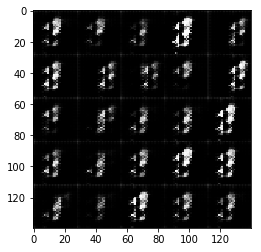

Epoch 1/2... Batch 110... Discriminator Loss: 0.5472... Generator Loss: 2.4628
Epoch 1/2... Batch 120... Discriminator Loss: 0.7036... Generator Loss: 3.0919
Epoch 1/2... Batch 130... Discriminator Loss: 0.4678... Generator Loss: 1.5367
Epoch 1/2... Batch 140... Discriminator Loss: 0.3511... Generator Loss: 2.4116
Epoch 1/2... Batch 150... Discriminator Loss: 0.2301... Generator Loss: 3.1343
Epoch 1/2... Batch 160... Discriminator Loss: 0.9504... Generator Loss: 6.7305
Epoch 1/2... Batch 170... Discriminator Loss: 0.2150... Generator Loss: 2.9433
Epoch 1/2... Batch 180... Discriminator Loss: 0.2476... Generator Loss: 2.7528
Epoch 1/2... Batch 190... Discriminator Loss: 0.1404... Generator Loss: 5.5007
Epoch 1/2... Batch 200... Discriminator Loss: 0.4323... Generator Loss: 2.6394


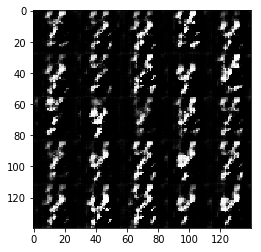

Epoch 1/2... Batch 210... Discriminator Loss: 0.7714... Generator Loss: 1.2607
Epoch 1/2... Batch 220... Discriminator Loss: 0.2253... Generator Loss: 3.1668
Epoch 1/2... Batch 230... Discriminator Loss: 0.6284... Generator Loss: 5.8754
Epoch 1/2... Batch 240... Discriminator Loss: 0.2333... Generator Loss: 4.7129
Epoch 1/2... Batch 250... Discriminator Loss: 0.3738... Generator Loss: 2.4521
Epoch 1/2... Batch 260... Discriminator Loss: 0.4930... Generator Loss: 4.2517
Epoch 1/2... Batch 270... Discriminator Loss: 0.1947... Generator Loss: 2.8335
Epoch 1/2... Batch 280... Discriminator Loss: 0.5961... Generator Loss: 2.1089
Epoch 1/2... Batch 290... Discriminator Loss: 0.6738... Generator Loss: 1.3319
Epoch 1/2... Batch 300... Discriminator Loss: 0.1769... Generator Loss: 2.5297


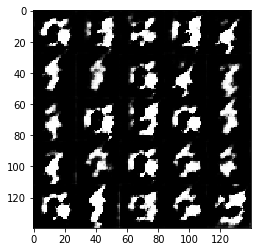

Epoch 1/2... Batch 310... Discriminator Loss: 0.1849... Generator Loss: 2.8261
Epoch 1/2... Batch 320... Discriminator Loss: 0.2768... Generator Loss: 2.2417
Epoch 1/2... Batch 330... Discriminator Loss: 0.4958... Generator Loss: 1.4481
Epoch 1/2... Batch 340... Discriminator Loss: 0.7387... Generator Loss: 1.0195
Epoch 1/2... Batch 350... Discriminator Loss: 0.4833... Generator Loss: 2.2981
Epoch 1/2... Batch 360... Discriminator Loss: 0.3287... Generator Loss: 3.2534
Epoch 1/2... Batch 370... Discriminator Loss: 0.2563... Generator Loss: 2.6131
Epoch 1/2... Batch 380... Discriminator Loss: 0.2877... Generator Loss: 2.5252
Epoch 1/2... Batch 390... Discriminator Loss: 0.6779... Generator Loss: 3.1915
Epoch 1/2... Batch 400... Discriminator Loss: 0.4001... Generator Loss: 1.7783


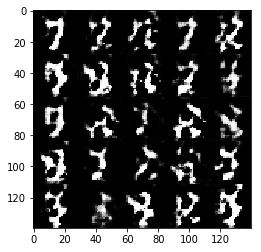

Epoch 1/2... Batch 410... Discriminator Loss: 0.3355... Generator Loss: 1.8848
Epoch 1/2... Batch 420... Discriminator Loss: 0.6816... Generator Loss: 1.1636
Epoch 1/2... Batch 430... Discriminator Loss: 0.3566... Generator Loss: 3.8363
Epoch 1/2... Batch 440... Discriminator Loss: 0.8740... Generator Loss: 2.0115
Epoch 1/2... Batch 450... Discriminator Loss: 0.5151... Generator Loss: 1.8703
Epoch 1/2... Batch 460... Discriminator Loss: 0.4460... Generator Loss: 2.3789


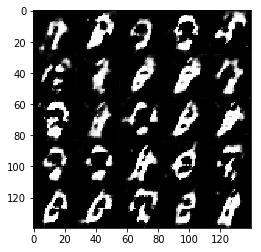

Epoch 2/2... Batch 10... Discriminator Loss: 0.5510... Generator Loss: 2.0464
Epoch 2/2... Batch 20... Discriminator Loss: 0.5536... Generator Loss: 2.2953
Epoch 2/2... Batch 30... Discriminator Loss: 0.5008... Generator Loss: 2.0797
Epoch 2/2... Batch 40... Discriminator Loss: 0.3024... Generator Loss: 2.8193
Epoch 2/2... Batch 50... Discriminator Loss: 0.6378... Generator Loss: 2.3732
Epoch 2/2... Batch 60... Discriminator Loss: 0.5753... Generator Loss: 1.4818
Epoch 2/2... Batch 70... Discriminator Loss: 0.4959... Generator Loss: 1.7123
Epoch 2/2... Batch 80... Discriminator Loss: 0.4971... Generator Loss: 1.6307
Epoch 2/2... Batch 90... Discriminator Loss: 0.5933... Generator Loss: 1.5812
Epoch 2/2... Batch 100... Discriminator Loss: 1.2953... Generator Loss: 4.5820


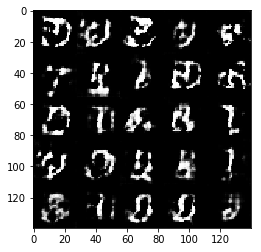

Epoch 2/2... Batch 110... Discriminator Loss: 0.7241... Generator Loss: 1.2822
Epoch 2/2... Batch 120... Discriminator Loss: 0.5382... Generator Loss: 1.6327
Epoch 2/2... Batch 130... Discriminator Loss: 0.5161... Generator Loss: 1.5991
Epoch 2/2... Batch 140... Discriminator Loss: 0.6695... Generator Loss: 1.0761
Epoch 2/2... Batch 150... Discriminator Loss: 0.4517... Generator Loss: 1.9990
Epoch 2/2... Batch 160... Discriminator Loss: 0.7004... Generator Loss: 1.7348
Epoch 2/2... Batch 170... Discriminator Loss: 1.2490... Generator Loss: 0.5694
Epoch 2/2... Batch 180... Discriminator Loss: 0.5751... Generator Loss: 1.8367
Epoch 2/2... Batch 190... Discriminator Loss: 1.3881... Generator Loss: 4.2008
Epoch 2/2... Batch 200... Discriminator Loss: 0.7121... Generator Loss: 1.9227


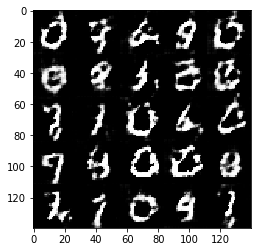

Epoch 2/2... Batch 210... Discriminator Loss: 0.8066... Generator Loss: 1.0576
Epoch 2/2... Batch 220... Discriminator Loss: 0.9618... Generator Loss: 0.7433
Epoch 2/2... Batch 230... Discriminator Loss: 0.7770... Generator Loss: 1.0328
Epoch 2/2... Batch 240... Discriminator Loss: 0.6039... Generator Loss: 1.7490
Epoch 2/2... Batch 250... Discriminator Loss: 0.5816... Generator Loss: 1.3783
Epoch 2/2... Batch 260... Discriminator Loss: 0.5752... Generator Loss: 1.9783
Epoch 2/2... Batch 270... Discriminator Loss: 0.6701... Generator Loss: 1.8650
Epoch 2/2... Batch 280... Discriminator Loss: 0.6012... Generator Loss: 1.3273
Epoch 2/2... Batch 290... Discriminator Loss: 0.6091... Generator Loss: 1.3217
Epoch 2/2... Batch 300... Discriminator Loss: 0.7749... Generator Loss: 0.9415


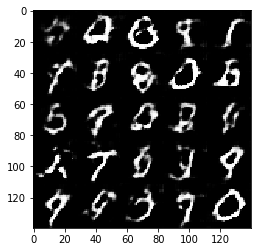

Epoch 2/2... Batch 310... Discriminator Loss: 0.7950... Generator Loss: 2.2071
Epoch 2/2... Batch 320... Discriminator Loss: 0.8619... Generator Loss: 1.0403
Epoch 2/2... Batch 330... Discriminator Loss: 0.9458... Generator Loss: 2.1725
Epoch 2/2... Batch 340... Discriminator Loss: 0.6594... Generator Loss: 1.3695
Epoch 2/2... Batch 350... Discriminator Loss: 0.7272... Generator Loss: 1.0497
Epoch 2/2... Batch 360... Discriminator Loss: 0.9060... Generator Loss: 1.0906
Epoch 2/2... Batch 370... Discriminator Loss: 0.5743... Generator Loss: 1.5606
Epoch 2/2... Batch 380... Discriminator Loss: 0.6831... Generator Loss: 1.6088
Epoch 2/2... Batch 390... Discriminator Loss: 0.7337... Generator Loss: 1.6160
Epoch 2/2... Batch 400... Discriminator Loss: 0.6775... Generator Loss: 1.3627


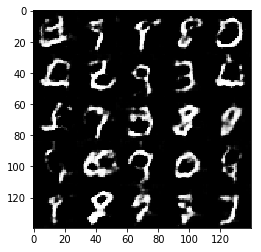

Epoch 2/2... Batch 410... Discriminator Loss: 0.6272... Generator Loss: 1.4436
Epoch 2/2... Batch 420... Discriminator Loss: 0.7251... Generator Loss: 2.3308
Epoch 2/2... Batch 430... Discriminator Loss: 0.8548... Generator Loss: 2.0223
Epoch 2/2... Batch 440... Discriminator Loss: 0.7240... Generator Loss: 1.0914
Epoch 2/2... Batch 450... Discriminator Loss: 0.6844... Generator Loss: 1.3403
Epoch 2/2... Batch 460... Discriminator Loss: 0.7087... Generator Loss: 1.4299


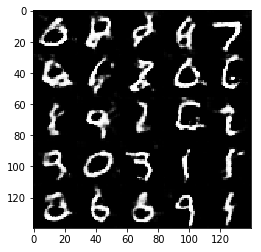

In [39]:
batch_size = 128
z_dim = 128
lr = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, lr, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Batch 10... Discriminator Loss: 0.3449... Generator Loss: 1.7210
Epoch 1/2... Batch 20... Discriminator Loss: 0.1587... Generator Loss: 2.5398
Epoch 1/2... Batch 30... Discriminator Loss: 0.1602... Generator Loss: 2.4769
Epoch 1/2... Batch 40... Discriminator Loss: 0.2187... Generator Loss: 2.2950
Epoch 1/2... Batch 50... Discriminator Loss: 0.8271... Generator Loss: 0.7871
Epoch 1/2... Batch 60... Discriminator Loss: 0.4375... Generator Loss: 1.6028
Epoch 1/2... Batch 70... Discriminator Loss: 0.3968... Generator Loss: 1.6597
Epoch 1/2... Batch 80... Discriminator Loss: 0.4511... Generator Loss: 1.5071
Epoch 1/2... Batch 90... Discriminator Loss: 0.3134... Generator Loss: 2.6829
Epoch 1/2... Batch 100... Discriminator Loss: 0.1731... Generator Loss: 2.5752


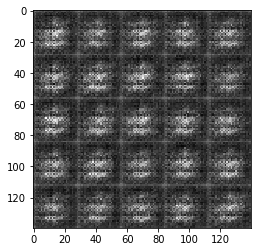

Epoch 1/2... Batch 110... Discriminator Loss: 0.1546... Generator Loss: 2.8299
Epoch 1/2... Batch 120... Discriminator Loss: 0.2025... Generator Loss: 2.3890
Epoch 1/2... Batch 130... Discriminator Loss: 0.0841... Generator Loss: 4.1677
Epoch 1/2... Batch 140... Discriminator Loss: 0.2190... Generator Loss: 2.6351
Epoch 1/2... Batch 150... Discriminator Loss: 0.1277... Generator Loss: 3.2993
Epoch 1/2... Batch 160... Discriminator Loss: 0.1154... Generator Loss: 3.2027
Epoch 1/2... Batch 170... Discriminator Loss: 0.0938... Generator Loss: 3.8127
Epoch 1/2... Batch 180... Discriminator Loss: 0.1079... Generator Loss: 3.2716
Epoch 1/2... Batch 190... Discriminator Loss: 0.1116... Generator Loss: 3.1285
Epoch 1/2... Batch 200... Discriminator Loss: 0.2208... Generator Loss: 4.2295


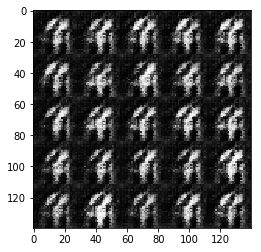

Epoch 1/2... Batch 210... Discriminator Loss: 0.1505... Generator Loss: 2.7839
Epoch 1/2... Batch 220... Discriminator Loss: 0.3178... Generator Loss: 1.9618
Epoch 1/2... Batch 230... Discriminator Loss: 0.2225... Generator Loss: 2.5056
Epoch 1/2... Batch 240... Discriminator Loss: 0.1838... Generator Loss: 2.2952
Epoch 1/2... Batch 250... Discriminator Loss: 0.1261... Generator Loss: 2.9987
Epoch 1/2... Batch 260... Discriminator Loss: 0.2279... Generator Loss: 2.7008
Epoch 1/2... Batch 270... Discriminator Loss: 0.1238... Generator Loss: 3.2443
Epoch 1/2... Batch 280... Discriminator Loss: 0.4391... Generator Loss: 1.7774
Epoch 1/2... Batch 290... Discriminator Loss: 0.2379... Generator Loss: 2.9578
Epoch 1/2... Batch 300... Discriminator Loss: 0.2101... Generator Loss: 3.0229


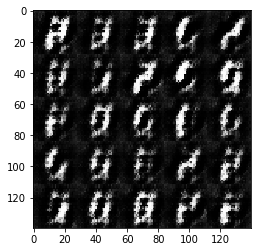

Epoch 1/2... Batch 310... Discriminator Loss: 0.1475... Generator Loss: 2.9013
Epoch 1/2... Batch 320... Discriminator Loss: 0.1534... Generator Loss: 3.1759
Epoch 1/2... Batch 330... Discriminator Loss: 0.1628... Generator Loss: 3.1028
Epoch 1/2... Batch 340... Discriminator Loss: 0.1596... Generator Loss: 2.9654
Epoch 1/2... Batch 350... Discriminator Loss: 0.1577... Generator Loss: 3.5361
Epoch 1/2... Batch 360... Discriminator Loss: 0.1475... Generator Loss: 2.9433
Epoch 1/2... Batch 370... Discriminator Loss: 0.4459... Generator Loss: 1.6303
Epoch 1/2... Batch 380... Discriminator Loss: 0.1976... Generator Loss: 2.8054
Epoch 1/2... Batch 390... Discriminator Loss: 0.2616... Generator Loss: 2.4807
Epoch 1/2... Batch 400... Discriminator Loss: 0.3195... Generator Loss: 1.8468


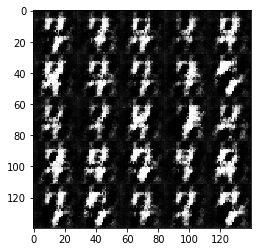

Epoch 1/2... Batch 410... Discriminator Loss: 0.2073... Generator Loss: 3.2710
Epoch 1/2... Batch 420... Discriminator Loss: 0.1013... Generator Loss: 3.4304
Epoch 1/2... Batch 430... Discriminator Loss: 0.1315... Generator Loss: 3.1039
Epoch 1/2... Batch 440... Discriminator Loss: 0.1304... Generator Loss: 3.2111
Epoch 1/2... Batch 450... Discriminator Loss: 0.2549... Generator Loss: 1.8367
Epoch 1/2... Batch 460... Discriminator Loss: 0.1546... Generator Loss: 2.8557
Epoch 1/2... Batch 470... Discriminator Loss: 0.0879... Generator Loss: 3.3016
Epoch 1/2... Batch 480... Discriminator Loss: 0.1324... Generator Loss: 3.1134
Epoch 1/2... Batch 490... Discriminator Loss: 0.0938... Generator Loss: 3.4543
Epoch 1/2... Batch 500... Discriminator Loss: 0.1349... Generator Loss: 3.5419


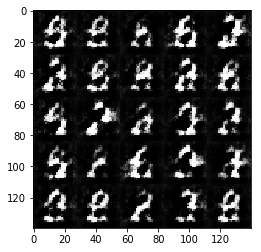

Epoch 1/2... Batch 510... Discriminator Loss: 0.6786... Generator Loss: 11.3685
Epoch 1/2... Batch 520... Discriminator Loss: 0.4616... Generator Loss: 1.5457
Epoch 1/2... Batch 530... Discriminator Loss: 0.9320... Generator Loss: 4.7044
Epoch 1/2... Batch 540... Discriminator Loss: 0.1211... Generator Loss: 3.1612
Epoch 1/2... Batch 550... Discriminator Loss: 0.1756... Generator Loss: 3.0527
Epoch 1/2... Batch 560... Discriminator Loss: 0.2069... Generator Loss: 2.8272
Epoch 1/2... Batch 570... Discriminator Loss: 0.1835... Generator Loss: 3.5028
Epoch 1/2... Batch 580... Discriminator Loss: 0.1436... Generator Loss: 2.8663
Epoch 1/2... Batch 590... Discriminator Loss: 0.2106... Generator Loss: 3.2548
Epoch 1/2... Batch 600... Discriminator Loss: 0.3292... Generator Loss: 4.9535


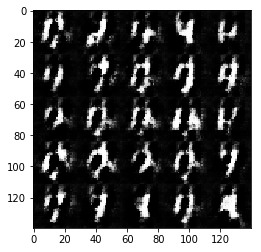

Epoch 1/2... Batch 610... Discriminator Loss: 0.1534... Generator Loss: 3.2760
Epoch 1/2... Batch 620... Discriminator Loss: 0.1752... Generator Loss: 3.3537
Epoch 1/2... Batch 630... Discriminator Loss: 0.1697... Generator Loss: 3.2678
Epoch 1/2... Batch 640... Discriminator Loss: 0.1894... Generator Loss: 3.2027
Epoch 1/2... Batch 650... Discriminator Loss: 0.1638... Generator Loss: 3.0730
Epoch 1/2... Batch 660... Discriminator Loss: 0.1547... Generator Loss: 2.8758
Epoch 1/2... Batch 670... Discriminator Loss: 0.1194... Generator Loss: 3.2559
Epoch 1/2... Batch 680... Discriminator Loss: 0.3830... Generator Loss: 1.9741
Epoch 1/2... Batch 690... Discriminator Loss: 0.1109... Generator Loss: 4.0590
Epoch 1/2... Batch 700... Discriminator Loss: 0.1871... Generator Loss: 2.6226


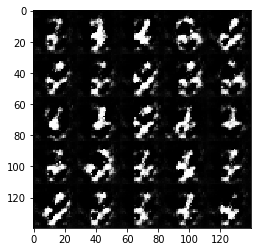

Epoch 1/2... Batch 710... Discriminator Loss: 0.6216... Generator Loss: 1.1385
Epoch 1/2... Batch 720... Discriminator Loss: 0.1338... Generator Loss: 3.4984
Epoch 1/2... Batch 730... Discriminator Loss: 0.4471... Generator Loss: 5.5676
Epoch 1/2... Batch 740... Discriminator Loss: 0.2233... Generator Loss: 2.7137
Epoch 1/2... Batch 750... Discriminator Loss: 0.3166... Generator Loss: 1.9436
Epoch 1/2... Batch 760... Discriminator Loss: 0.1215... Generator Loss: 3.2253
Epoch 1/2... Batch 770... Discriminator Loss: 0.1388... Generator Loss: 3.3827
Epoch 1/2... Batch 780... Discriminator Loss: 0.3723... Generator Loss: 1.7384
Epoch 1/2... Batch 790... Discriminator Loss: 0.5780... Generator Loss: 1.4625
Epoch 1/2... Batch 800... Discriminator Loss: 0.2560... Generator Loss: 2.4834


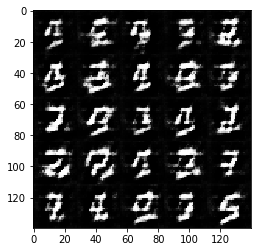

Epoch 1/2... Batch 810... Discriminator Loss: 0.2799... Generator Loss: 3.2801
Epoch 1/2... Batch 820... Discriminator Loss: 0.2217... Generator Loss: 2.9710
Epoch 1/2... Batch 830... Discriminator Loss: 0.2824... Generator Loss: 2.1327
Epoch 1/2... Batch 840... Discriminator Loss: 3.4523... Generator Loss: 8.2883
Epoch 1/2... Batch 850... Discriminator Loss: 0.2966... Generator Loss: 2.3902
Epoch 1/2... Batch 860... Discriminator Loss: 0.2050... Generator Loss: 3.6211
Epoch 1/2... Batch 870... Discriminator Loss: 0.2714... Generator Loss: 3.2017
Epoch 1/2... Batch 880... Discriminator Loss: 0.2242... Generator Loss: 2.8460
Epoch 1/2... Batch 890... Discriminator Loss: 0.2401... Generator Loss: 2.5287
Epoch 1/2... Batch 900... Discriminator Loss: 0.3284... Generator Loss: 2.0891


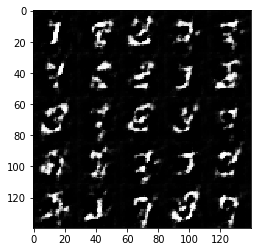

Epoch 1/2... Batch 910... Discriminator Loss: 0.2161... Generator Loss: 2.5817
Epoch 1/2... Batch 920... Discriminator Loss: 0.2130... Generator Loss: 3.4164
Epoch 1/2... Batch 930... Discriminator Loss: 1.0004... Generator Loss: 4.8436


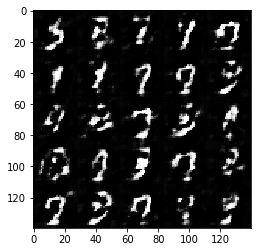

Epoch 2/2... Batch 10... Discriminator Loss: 0.3465... Generator Loss: 1.9843
Epoch 2/2... Batch 20... Discriminator Loss: 0.3479... Generator Loss: 1.8816
Epoch 2/2... Batch 30... Discriminator Loss: 0.3989... Generator Loss: 1.8971
Epoch 2/2... Batch 40... Discriminator Loss: 0.3356... Generator Loss: 2.7572
Epoch 2/2... Batch 50... Discriminator Loss: 0.5941... Generator Loss: 1.2030
Epoch 2/2... Batch 60... Discriminator Loss: 0.6106... Generator Loss: 1.4099
Epoch 2/2... Batch 70... Discriminator Loss: 0.3130... Generator Loss: 2.0058
Epoch 2/2... Batch 80... Discriminator Loss: 0.3434... Generator Loss: 1.8056
Epoch 2/2... Batch 90... Discriminator Loss: 0.3110... Generator Loss: 2.8217
Epoch 2/2... Batch 100... Discriminator Loss: 0.2289... Generator Loss: 3.5432


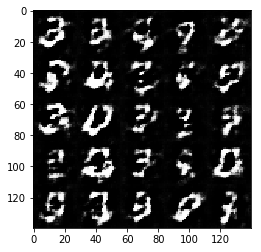

Epoch 2/2... Batch 110... Discriminator Loss: 0.2978... Generator Loss: 2.1742
Epoch 2/2... Batch 120... Discriminator Loss: 0.2485... Generator Loss: 2.7310
Epoch 2/2... Batch 130... Discriminator Loss: 0.4848... Generator Loss: 1.4929
Epoch 2/2... Batch 140... Discriminator Loss: 0.4512... Generator Loss: 2.4843
Epoch 2/2... Batch 150... Discriminator Loss: 0.3273... Generator Loss: 2.9353
Epoch 2/2... Batch 160... Discriminator Loss: 0.2584... Generator Loss: 2.8499
Epoch 2/2... Batch 170... Discriminator Loss: 0.3033... Generator Loss: 2.0496
Epoch 2/2... Batch 180... Discriminator Loss: 0.3054... Generator Loss: 3.5400
Epoch 2/2... Batch 190... Discriminator Loss: 0.3277... Generator Loss: 1.9492
Epoch 2/2... Batch 200... Discriminator Loss: 0.2858... Generator Loss: 2.4392


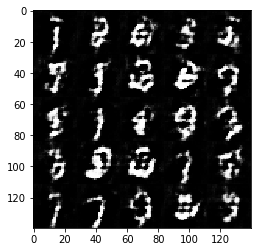

Epoch 2/2... Batch 210... Discriminator Loss: 0.2556... Generator Loss: 3.4472
Epoch 2/2... Batch 220... Discriminator Loss: 0.2886... Generator Loss: 3.1423
Epoch 2/2... Batch 230... Discriminator Loss: 2.6570... Generator Loss: 0.1883
Epoch 2/2... Batch 240... Discriminator Loss: 0.4991... Generator Loss: 1.4325
Epoch 2/2... Batch 250... Discriminator Loss: 0.3440... Generator Loss: 1.9353
Epoch 2/2... Batch 260... Discriminator Loss: 0.2871... Generator Loss: 2.1186
Epoch 2/2... Batch 270... Discriminator Loss: 0.3790... Generator Loss: 2.0009
Epoch 2/2... Batch 280... Discriminator Loss: 0.3935... Generator Loss: 2.4316
Epoch 2/2... Batch 290... Discriminator Loss: 0.6504... Generator Loss: 1.0488
Epoch 2/2... Batch 300... Discriminator Loss: 0.2701... Generator Loss: 2.4523


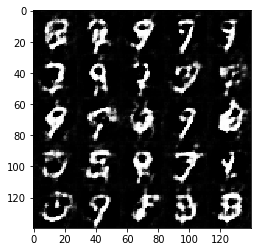

Epoch 2/2... Batch 310... Discriminator Loss: 0.2892... Generator Loss: 2.6703
Epoch 2/2... Batch 320... Discriminator Loss: 0.5226... Generator Loss: 3.3343
Epoch 2/2... Batch 330... Discriminator Loss: 0.2417... Generator Loss: 2.5357
Epoch 2/2... Batch 340... Discriminator Loss: 0.3036... Generator Loss: 2.6187
Epoch 2/2... Batch 350... Discriminator Loss: 0.3274... Generator Loss: 3.4273
Epoch 2/2... Batch 360... Discriminator Loss: 0.4569... Generator Loss: 1.4557
Epoch 2/2... Batch 370... Discriminator Loss: 0.4165... Generator Loss: 1.6245
Epoch 2/2... Batch 380... Discriminator Loss: 0.2795... Generator Loss: 2.5241
Epoch 2/2... Batch 390... Discriminator Loss: 0.4163... Generator Loss: 1.8793
Epoch 2/2... Batch 400... Discriminator Loss: 0.3711... Generator Loss: 2.0879


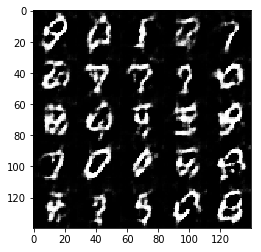

Epoch 2/2... Batch 410... Discriminator Loss: 0.2960... Generator Loss: 2.3718
Epoch 2/2... Batch 420... Discriminator Loss: 0.4071... Generator Loss: 1.8792
Epoch 2/2... Batch 430... Discriminator Loss: 0.3772... Generator Loss: 3.2000
Epoch 2/2... Batch 440... Discriminator Loss: 0.3806... Generator Loss: 1.9626
Epoch 2/2... Batch 450... Discriminator Loss: 0.3190... Generator Loss: 2.3854
Epoch 2/2... Batch 460... Discriminator Loss: 0.3651... Generator Loss: 3.1923
Epoch 2/2... Batch 470... Discriminator Loss: 0.8835... Generator Loss: 0.8539
Epoch 2/2... Batch 480... Discriminator Loss: 0.2751... Generator Loss: 2.4175
Epoch 2/2... Batch 490... Discriminator Loss: 0.4804... Generator Loss: 2.4133
Epoch 2/2... Batch 500... Discriminator Loss: 0.4699... Generator Loss: 1.5131


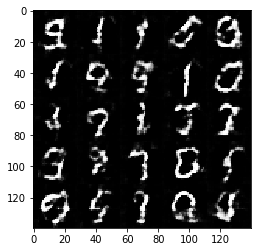

Epoch 2/2... Batch 510... Discriminator Loss: 0.5192... Generator Loss: 2.4246
Epoch 2/2... Batch 520... Discriminator Loss: 0.4583... Generator Loss: 1.8901
Epoch 2/2... Batch 530... Discriminator Loss: 0.7590... Generator Loss: 3.4920
Epoch 2/2... Batch 540... Discriminator Loss: 0.3612... Generator Loss: 2.0039
Epoch 2/2... Batch 550... Discriminator Loss: 0.4575... Generator Loss: 2.2784
Epoch 2/2... Batch 560... Discriminator Loss: 0.9370... Generator Loss: 0.8560
Epoch 2/2... Batch 570... Discriminator Loss: 1.1625... Generator Loss: 0.5725
Epoch 2/2... Batch 580... Discriminator Loss: 0.4121... Generator Loss: 1.9250
Epoch 2/2... Batch 590... Discriminator Loss: 0.4589... Generator Loss: 1.8463
Epoch 2/2... Batch 600... Discriminator Loss: 0.5946... Generator Loss: 2.8297


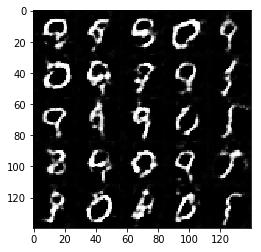

Epoch 2/2... Batch 610... Discriminator Loss: 0.3844... Generator Loss: 2.1087
Epoch 2/2... Batch 620... Discriminator Loss: 0.4863... Generator Loss: 2.1245
Epoch 2/2... Batch 630... Discriminator Loss: 0.5294... Generator Loss: 2.6069
Epoch 2/2... Batch 640... Discriminator Loss: 0.4051... Generator Loss: 2.5697
Epoch 2/2... Batch 650... Discriminator Loss: 0.4810... Generator Loss: 1.9766
Epoch 2/2... Batch 660... Discriminator Loss: 0.4799... Generator Loss: 1.7019
Epoch 2/2... Batch 670... Discriminator Loss: 0.6549... Generator Loss: 2.3769
Epoch 2/2... Batch 680... Discriminator Loss: 1.0735... Generator Loss: 0.6555
Epoch 2/2... Batch 690... Discriminator Loss: 0.4975... Generator Loss: 1.6638
Epoch 2/2... Batch 700... Discriminator Loss: 0.4384... Generator Loss: 1.9259


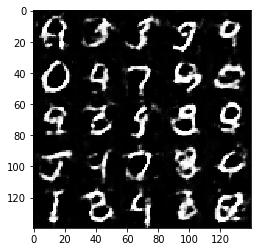

Epoch 2/2... Batch 710... Discriminator Loss: 1.0966... Generator Loss: 0.8615
Epoch 2/2... Batch 720... Discriminator Loss: 0.5034... Generator Loss: 1.4577
Epoch 2/2... Batch 730... Discriminator Loss: 0.5504... Generator Loss: 1.4503
Epoch 2/2... Batch 740... Discriminator Loss: 0.7143... Generator Loss: 0.9755
Epoch 2/2... Batch 750... Discriminator Loss: 0.4271... Generator Loss: 1.7407
Epoch 2/2... Batch 760... Discriminator Loss: 0.5062... Generator Loss: 1.3734
Epoch 2/2... Batch 770... Discriminator Loss: 0.6346... Generator Loss: 2.4679
Epoch 2/2... Batch 780... Discriminator Loss: 0.8305... Generator Loss: 0.8109
Epoch 2/2... Batch 790... Discriminator Loss: 0.5788... Generator Loss: 1.3343
Epoch 2/2... Batch 800... Discriminator Loss: 0.6608... Generator Loss: 1.2018


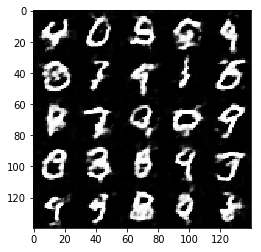

Epoch 2/2... Batch 810... Discriminator Loss: 0.5810... Generator Loss: 1.3760
Epoch 2/2... Batch 820... Discriminator Loss: 0.5723... Generator Loss: 1.8237
Epoch 2/2... Batch 830... Discriminator Loss: 0.5108... Generator Loss: 1.5215
Epoch 2/2... Batch 840... Discriminator Loss: 0.4124... Generator Loss: 1.7364
Epoch 2/2... Batch 850... Discriminator Loss: 0.4034... Generator Loss: 1.7952
Epoch 2/2... Batch 860... Discriminator Loss: 1.0974... Generator Loss: 0.7334
Epoch 2/2... Batch 870... Discriminator Loss: 0.7818... Generator Loss: 2.2064
Epoch 2/2... Batch 880... Discriminator Loss: 0.7501... Generator Loss: 2.2817
Epoch 2/2... Batch 890... Discriminator Loss: 0.6827... Generator Loss: 1.2082
Epoch 2/2... Batch 900... Discriminator Loss: 0.5481... Generator Loss: 1.2566


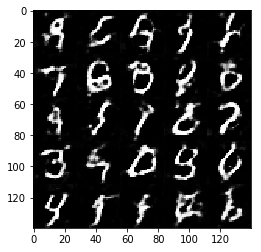

Epoch 2/2... Batch 910... Discriminator Loss: 0.7837... Generator Loss: 0.8763
Epoch 2/2... Batch 920... Discriminator Loss: 0.4824... Generator Loss: 1.4367
Epoch 2/2... Batch 930... Discriminator Loss: 0.5688... Generator Loss: 1.8883


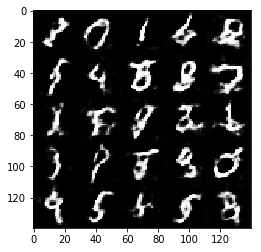

In [38]:
batch_size = 64
z_dim = 128
lr = 0.0001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, lr, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Batch 10... Discriminator Loss: 0.3645... Generator Loss: 1.9792
Epoch 1/2... Batch 20... Discriminator Loss: 0.2049... Generator Loss: 8.9651
Epoch 1/2... Batch 30... Discriminator Loss: 0.1924... Generator Loss: 3.5853
Epoch 1/2... Batch 40... Discriminator Loss: 2.7621... Generator Loss: 0.1641
Epoch 1/2... Batch 50... Discriminator Loss: 0.5120... Generator Loss: 2.8571
Epoch 1/2... Batch 60... Discriminator Loss: 0.3366... Generator Loss: 2.6574
Epoch 1/2... Batch 70... Discriminator Loss: 0.0914... Generator Loss: 3.4784
Epoch 1/2... Batch 80... Discriminator Loss: 0.6212... Generator Loss: 1.0638
Epoch 1/2... Batch 90... Discriminator Loss: 0.4091... Generator Loss: 2.5661
Epoch 1/2... Batch 100... Discriminator Loss: 0.1683... Generator Loss: 2.6044


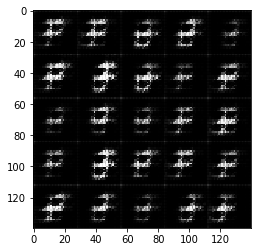

Epoch 1/2... Batch 110... Discriminator Loss: 0.1110... Generator Loss: 3.8532
Epoch 1/2... Batch 120... Discriminator Loss: 0.0489... Generator Loss: 5.3297
Epoch 1/2... Batch 130... Discriminator Loss: 0.6999... Generator Loss: 2.4222
Epoch 1/2... Batch 140... Discriminator Loss: 0.1359... Generator Loss: 3.3881
Epoch 1/2... Batch 150... Discriminator Loss: 0.4457... Generator Loss: 1.4922
Epoch 1/2... Batch 160... Discriminator Loss: 0.4050... Generator Loss: 3.2322
Epoch 1/2... Batch 170... Discriminator Loss: 0.8559... Generator Loss: 0.9217
Epoch 1/2... Batch 180... Discriminator Loss: 0.1574... Generator Loss: 2.7496
Epoch 1/2... Batch 190... Discriminator Loss: 0.4196... Generator Loss: 2.3872
Epoch 1/2... Batch 200... Discriminator Loss: 0.4533... Generator Loss: 1.9689


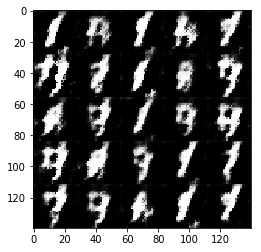

Epoch 1/2... Batch 210... Discriminator Loss: 0.3585... Generator Loss: 1.5042
Epoch 1/2... Batch 220... Discriminator Loss: 1.7735... Generator Loss: 0.3744
Epoch 1/2... Batch 230... Discriminator Loss: 0.5530... Generator Loss: 2.2153
Epoch 1/2... Batch 240... Discriminator Loss: 0.4605... Generator Loss: 1.9346
Epoch 1/2... Batch 250... Discriminator Loss: 0.1749... Generator Loss: 2.8550
Epoch 1/2... Batch 260... Discriminator Loss: 0.4391... Generator Loss: 1.6097
Epoch 1/2... Batch 270... Discriminator Loss: 0.5489... Generator Loss: 1.3098
Epoch 1/2... Batch 280... Discriminator Loss: 0.3063... Generator Loss: 2.0639
Epoch 1/2... Batch 290... Discriminator Loss: 0.3530... Generator Loss: 2.0592
Epoch 1/2... Batch 300... Discriminator Loss: 0.5663... Generator Loss: 1.9507


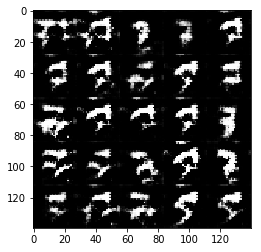

Epoch 1/2... Batch 310... Discriminator Loss: 0.5128... Generator Loss: 1.9903
Epoch 1/2... Batch 320... Discriminator Loss: 0.3836... Generator Loss: 2.2909
Epoch 1/2... Batch 330... Discriminator Loss: 0.3139... Generator Loss: 2.2013
Epoch 1/2... Batch 340... Discriminator Loss: 0.3574... Generator Loss: 2.2250
Epoch 1/2... Batch 350... Discriminator Loss: 0.1422... Generator Loss: 3.3844
Epoch 1/2... Batch 360... Discriminator Loss: 0.3257... Generator Loss: 2.3694
Epoch 1/2... Batch 370... Discriminator Loss: 0.3529... Generator Loss: 2.1832
Epoch 1/2... Batch 380... Discriminator Loss: 0.4593... Generator Loss: 1.8863
Epoch 1/2... Batch 390... Discriminator Loss: 0.2957... Generator Loss: 2.4329
Epoch 1/2... Batch 400... Discriminator Loss: 0.2667... Generator Loss: 2.4367


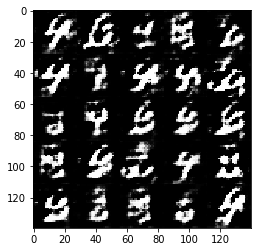

Epoch 1/2... Batch 410... Discriminator Loss: 0.3802... Generator Loss: 2.0165
Epoch 1/2... Batch 420... Discriminator Loss: 0.5948... Generator Loss: 5.1714
Epoch 1/2... Batch 430... Discriminator Loss: 0.6236... Generator Loss: 2.7214
Epoch 1/2... Batch 440... Discriminator Loss: 0.2952... Generator Loss: 2.3646
Epoch 1/2... Batch 450... Discriminator Loss: 0.2973... Generator Loss: 2.6676
Epoch 1/2... Batch 460... Discriminator Loss: 0.9091... Generator Loss: 0.8374
Epoch 2/2... Batch 10... Discriminator Loss: 0.6188... Generator Loss: 1.4251
Epoch 2/2... Batch 20... Discriminator Loss: 0.2949... Generator Loss: 2.7464
Epoch 2/2... Batch 30... Discriminator Loss: 0.3607... Generator Loss: 2.4404
Epoch 2/2... Batch 40... Discriminator Loss: 0.6091... Generator Loss: 2.1730
Epoch 2/2... Batch 50... Discriminator Loss: 0.5261... Generator Loss: 1.5619
Epoch 2/2... Batch 60... Discriminator Loss: 0.6593... Generator Loss: 2.6851
Epoch 2/2... Batch 70... Discriminator Loss: 0.5788... Gen

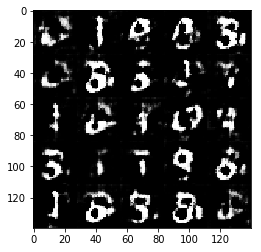

Epoch 2/2... Batch 110... Discriminator Loss: 0.5635... Generator Loss: 2.3106
Epoch 2/2... Batch 120... Discriminator Loss: 0.4877... Generator Loss: 4.0150
Epoch 2/2... Batch 130... Discriminator Loss: 0.8083... Generator Loss: 1.4762
Epoch 2/2... Batch 140... Discriminator Loss: 1.0686... Generator Loss: 0.6900
Epoch 2/2... Batch 150... Discriminator Loss: 0.4956... Generator Loss: 1.7452
Epoch 2/2... Batch 160... Discriminator Loss: 0.7327... Generator Loss: 0.9619
Epoch 2/2... Batch 170... Discriminator Loss: 0.5722... Generator Loss: 1.4520
Epoch 2/2... Batch 180... Discriminator Loss: 0.5130... Generator Loss: 2.5347
Epoch 2/2... Batch 190... Discriminator Loss: 0.7212... Generator Loss: 1.0962
Epoch 2/2... Batch 200... Discriminator Loss: 0.7585... Generator Loss: 1.2883


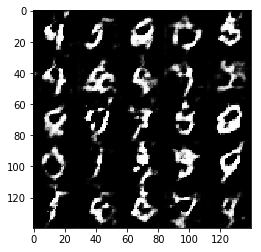

Epoch 2/2... Batch 210... Discriminator Loss: 0.7831... Generator Loss: 1.4624
Epoch 2/2... Batch 220... Discriminator Loss: 0.4849... Generator Loss: 2.0125
Epoch 2/2... Batch 230... Discriminator Loss: 0.6535... Generator Loss: 1.3860
Epoch 2/2... Batch 240... Discriminator Loss: 0.5322... Generator Loss: 1.4552
Epoch 2/2... Batch 250... Discriminator Loss: 0.5860... Generator Loss: 1.4940
Epoch 2/2... Batch 260... Discriminator Loss: 0.5011... Generator Loss: 1.7088
Epoch 2/2... Batch 270... Discriminator Loss: 0.5507... Generator Loss: 1.7350
Epoch 2/2... Batch 280... Discriminator Loss: 0.5917... Generator Loss: 1.6003
Epoch 2/2... Batch 290... Discriminator Loss: 0.6504... Generator Loss: 1.3902
Epoch 2/2... Batch 300... Discriminator Loss: 1.1873... Generator Loss: 0.5654


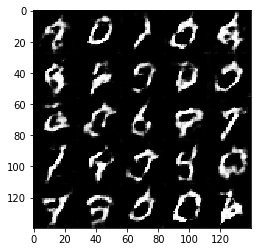

Epoch 2/2... Batch 310... Discriminator Loss: 0.7052... Generator Loss: 1.2401
Epoch 2/2... Batch 320... Discriminator Loss: 1.4349... Generator Loss: 3.8542
Epoch 2/2... Batch 330... Discriminator Loss: 0.7847... Generator Loss: 1.3979
Epoch 2/2... Batch 340... Discriminator Loss: 0.8707... Generator Loss: 0.9604
Epoch 2/2... Batch 350... Discriminator Loss: 0.8560... Generator Loss: 1.5269
Epoch 2/2... Batch 360... Discriminator Loss: 1.0144... Generator Loss: 0.7568
Epoch 2/2... Batch 370... Discriminator Loss: 0.9470... Generator Loss: 2.8030
Epoch 2/2... Batch 380... Discriminator Loss: 0.5608... Generator Loss: 1.7910
Epoch 2/2... Batch 390... Discriminator Loss: 1.0980... Generator Loss: 1.5198
Epoch 2/2... Batch 400... Discriminator Loss: 0.8414... Generator Loss: 1.0267


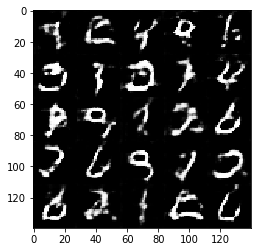

Epoch 2/2... Batch 410... Discriminator Loss: 0.7663... Generator Loss: 1.8122
Epoch 2/2... Batch 420... Discriminator Loss: 0.7371... Generator Loss: 0.9880
Epoch 2/2... Batch 430... Discriminator Loss: 1.0717... Generator Loss: 2.1179
Epoch 2/2... Batch 440... Discriminator Loss: 0.6571... Generator Loss: 1.2023
Epoch 2/2... Batch 450... Discriminator Loss: 0.8610... Generator Loss: 2.3068
Epoch 2/2... Batch 460... Discriminator Loss: 0.8608... Generator Loss: 1.0185


In [35]:
batch_size = 64
z_dim = 128
lr = 0.0001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, lr, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 5.3987... Generator Loss: 0.0138 Total Loss: 5.4125
Epoch 1/1... Batch 20... Discriminator Loss: 0.6116... Generator Loss: 1.4954 Total Loss: 2.1069
Epoch 1/1... Batch 30... Discriminator Loss: 1.0221... Generator Loss: 0.6778 Total Loss: 1.6999
Epoch 1/1... Batch 40... Discriminator Loss: 0.4476... Generator Loss: 2.7143 Total Loss: 3.1619
Epoch 1/1... Batch 50... Discriminator Loss: 0.4274... Generator Loss: 5.1455 Total Loss: 5.5729
Epoch 1/1... Batch 60... Discriminator Loss: 0.6644... Generator Loss: 0.9132 Total Loss: 1.5776
Epoch 1/1... Batch 70... Discriminator Loss: 0.2152... Generator Loss: 2.7888 Total Loss: 3.0039
Epoch 1/1... Batch 80... Discriminator Loss: 0.6010... Generator Loss: 1.3114 Total Loss: 1.9123
Epoch 1/1... Batch 90... Discriminator Loss: 0.3168... Generator Loss: 2.0990 Total Loss: 2.4158
Epoch 1/1... Batch 100... Discriminator Loss: 0.6054... Generator Loss: 3.6011 Total Loss: 4.2065


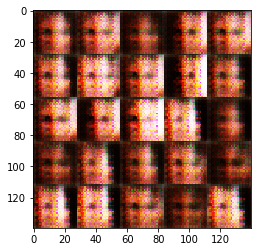

Epoch 1/1... Batch 110... Discriminator Loss: 0.2147... Generator Loss: 2.3975 Total Loss: 2.6122
Epoch 1/1... Batch 120... Discriminator Loss: 1.0564... Generator Loss: 0.5895 Total Loss: 1.6459
Epoch 1/1... Batch 130... Discriminator Loss: 0.4888... Generator Loss: 1.5487 Total Loss: 2.0375
Epoch 1/1... Batch 140... Discriminator Loss: 0.7598... Generator Loss: 1.7291 Total Loss: 2.4889
Epoch 1/1... Batch 150... Discriminator Loss: 0.3686... Generator Loss: 2.0592 Total Loss: 2.4278
Epoch 1/1... Batch 160... Discriminator Loss: 1.1178... Generator Loss: 0.9971 Total Loss: 2.1149
Epoch 1/1... Batch 170... Discriminator Loss: 0.3766... Generator Loss: 1.8304 Total Loss: 2.2070
Epoch 1/1... Batch 180... Discriminator Loss: 0.9901... Generator Loss: 1.8674 Total Loss: 2.8575
Epoch 1/1... Batch 190... Discriminator Loss: 1.1172... Generator Loss: 0.7242 Total Loss: 1.8414
Epoch 1/1... Batch 200... Discriminator Loss: 1.1670... Generator Loss: 0.8608 Total Loss: 2.0278


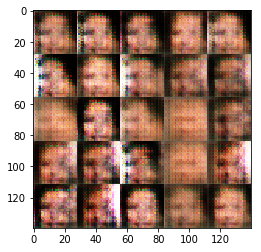

Epoch 1/1... Batch 210... Discriminator Loss: 1.1540... Generator Loss: 1.8192 Total Loss: 2.9733
Epoch 1/1... Batch 220... Discriminator Loss: 1.0545... Generator Loss: 1.0543 Total Loss: 2.1088
Epoch 1/1... Batch 230... Discriminator Loss: 0.8938... Generator Loss: 0.9971 Total Loss: 1.8909
Epoch 1/1... Batch 240... Discriminator Loss: 1.0965... Generator Loss: 0.8492 Total Loss: 1.9457
Epoch 1/1... Batch 250... Discriminator Loss: 1.4847... Generator Loss: 0.4316 Total Loss: 1.9163
Epoch 1/1... Batch 260... Discriminator Loss: 1.4698... Generator Loss: 0.5219 Total Loss: 1.9918
Epoch 1/1... Batch 270... Discriminator Loss: 0.8492... Generator Loss: 1.1378 Total Loss: 1.9870
Epoch 1/1... Batch 280... Discriminator Loss: 1.2010... Generator Loss: 0.8919 Total Loss: 2.0928
Epoch 1/1... Batch 290... Discriminator Loss: 1.1883... Generator Loss: 0.8788 Total Loss: 2.0671
Epoch 1/1... Batch 300... Discriminator Loss: 1.3110... Generator Loss: 0.6923 Total Loss: 2.0034


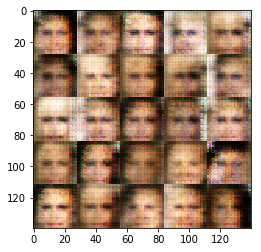

Epoch 1/1... Batch 310... Discriminator Loss: 1.1304... Generator Loss: 1.4766 Total Loss: 2.6069
Epoch 1/1... Batch 320... Discriminator Loss: 0.9066... Generator Loss: 1.1871 Total Loss: 2.0937
Epoch 1/1... Batch 330... Discriminator Loss: 1.2825... Generator Loss: 0.7714 Total Loss: 2.0538
Epoch 1/1... Batch 340... Discriminator Loss: 1.2217... Generator Loss: 0.5975 Total Loss: 1.8192
Epoch 1/1... Batch 350... Discriminator Loss: 1.1566... Generator Loss: 0.7088 Total Loss: 1.8654
Epoch 1/1... Batch 360... Discriminator Loss: 0.7251... Generator Loss: 1.4167 Total Loss: 2.1417
Epoch 1/1... Batch 370... Discriminator Loss: 1.0272... Generator Loss: 0.9898 Total Loss: 2.0170
Epoch 1/1... Batch 380... Discriminator Loss: 1.0539... Generator Loss: 0.9429 Total Loss: 1.9968
Epoch 1/1... Batch 390... Discriminator Loss: 0.7288... Generator Loss: 1.2897 Total Loss: 2.0186
Epoch 1/1... Batch 400... Discriminator Loss: 1.0269... Generator Loss: 1.5221 Total Loss: 2.5491


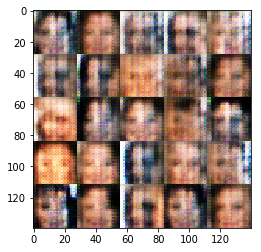

Epoch 1/1... Batch 410... Discriminator Loss: 1.4660... Generator Loss: 1.5596 Total Loss: 3.0255
Epoch 1/1... Batch 420... Discriminator Loss: 1.0499... Generator Loss: 1.6910 Total Loss: 2.7409
Epoch 1/1... Batch 430... Discriminator Loss: 1.0976... Generator Loss: 0.8157 Total Loss: 1.9133
Epoch 1/1... Batch 440... Discriminator Loss: 0.9975... Generator Loss: 1.3326 Total Loss: 2.3300
Epoch 1/1... Batch 450... Discriminator Loss: 0.7749... Generator Loss: 1.1464 Total Loss: 1.9213
Epoch 1/1... Batch 460... Discriminator Loss: 0.9021... Generator Loss: 1.0682 Total Loss: 1.9702
Epoch 1/1... Batch 470... Discriminator Loss: 1.0937... Generator Loss: 1.4302 Total Loss: 2.5239
Epoch 1/1... Batch 480... Discriminator Loss: 1.0912... Generator Loss: 0.9813 Total Loss: 2.0725
Epoch 1/1... Batch 490... Discriminator Loss: 0.6658... Generator Loss: 1.3076 Total Loss: 1.9734
Epoch 1/1... Batch 500... Discriminator Loss: 1.1222... Generator Loss: 0.9109 Total Loss: 2.0331


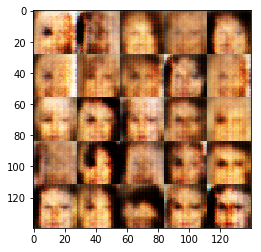

Epoch 1/1... Batch 510... Discriminator Loss: 0.9204... Generator Loss: 0.8769 Total Loss: 1.7973
Epoch 1/1... Batch 520... Discriminator Loss: 1.7523... Generator Loss: 0.3817 Total Loss: 2.1341
Epoch 1/1... Batch 530... Discriminator Loss: 1.2001... Generator Loss: 1.6252 Total Loss: 2.8253
Epoch 1/1... Batch 540... Discriminator Loss: 1.0645... Generator Loss: 1.0238 Total Loss: 2.0883
Epoch 1/1... Batch 550... Discriminator Loss: 0.9089... Generator Loss: 1.2948 Total Loss: 2.2038
Epoch 1/1... Batch 560... Discriminator Loss: 0.9513... Generator Loss: 1.2653 Total Loss: 2.2166
Epoch 1/1... Batch 570... Discriminator Loss: 0.7657... Generator Loss: 1.2661 Total Loss: 2.0318
Epoch 1/1... Batch 580... Discriminator Loss: 1.1264... Generator Loss: 2.0866 Total Loss: 3.2130
Epoch 1/1... Batch 590... Discriminator Loss: 0.9445... Generator Loss: 1.3547 Total Loss: 2.2992
Epoch 1/1... Batch 600... Discriminator Loss: 0.9122... Generator Loss: 1.9382 Total Loss: 2.8504


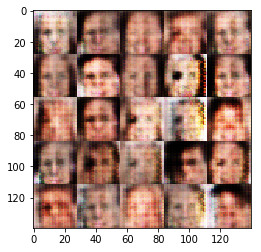

Epoch 1/1... Batch 610... Discriminator Loss: 1.0933... Generator Loss: 0.6911 Total Loss: 1.7844
Epoch 1/1... Batch 620... Discriminator Loss: 0.9823... Generator Loss: 1.1031 Total Loss: 2.0855
Epoch 1/1... Batch 630... Discriminator Loss: 1.0608... Generator Loss: 1.8711 Total Loss: 2.9319
Epoch 1/1... Batch 640... Discriminator Loss: 1.0976... Generator Loss: 0.6478 Total Loss: 1.7454
Epoch 1/1... Batch 650... Discriminator Loss: 0.8719... Generator Loss: 1.3799 Total Loss: 2.2518
Epoch 1/1... Batch 660... Discriminator Loss: 0.8946... Generator Loss: 1.0666 Total Loss: 1.9613
Epoch 1/1... Batch 670... Discriminator Loss: 0.9907... Generator Loss: 0.8688 Total Loss: 1.8595
Epoch 1/1... Batch 680... Discriminator Loss: 0.9692... Generator Loss: 1.4682 Total Loss: 2.4374
Epoch 1/1... Batch 690... Discriminator Loss: 1.0582... Generator Loss: 0.7114 Total Loss: 1.7696
Epoch 1/1... Batch 700... Discriminator Loss: 0.9694... Generator Loss: 0.9519 Total Loss: 1.9213


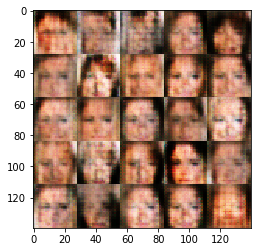

Epoch 1/1... Batch 710... Discriminator Loss: 0.7821... Generator Loss: 1.3263 Total Loss: 2.1084
Epoch 1/1... Batch 720... Discriminator Loss: 0.7795... Generator Loss: 1.0777 Total Loss: 1.8571
Epoch 1/1... Batch 730... Discriminator Loss: 0.9776... Generator Loss: 2.0060 Total Loss: 2.9837
Epoch 1/1... Batch 740... Discriminator Loss: 0.9758... Generator Loss: 1.5389 Total Loss: 2.5147
Epoch 1/1... Batch 750... Discriminator Loss: 1.2775... Generator Loss: 0.8569 Total Loss: 2.1344
Epoch 1/1... Batch 760... Discriminator Loss: 1.3638... Generator Loss: 0.4348 Total Loss: 1.7986
Epoch 1/1... Batch 770... Discriminator Loss: 1.0372... Generator Loss: 0.7855 Total Loss: 1.8227
Epoch 1/1... Batch 780... Discriminator Loss: 0.6590... Generator Loss: 1.5569 Total Loss: 2.2159
Epoch 1/1... Batch 790... Discriminator Loss: 1.0218... Generator Loss: 0.8450 Total Loss: 1.8669
Epoch 1/1... Batch 800... Discriminator Loss: 1.3266... Generator Loss: 0.5053 Total Loss: 1.8320


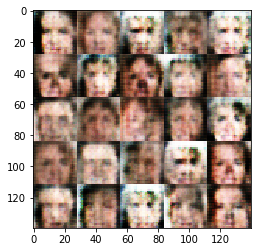

Epoch 1/1... Batch 810... Discriminator Loss: 0.8785... Generator Loss: 1.1541 Total Loss: 2.0327
Epoch 1/1... Batch 820... Discriminator Loss: 0.8476... Generator Loss: 1.0142 Total Loss: 1.8618
Epoch 1/1... Batch 830... Discriminator Loss: 1.0295... Generator Loss: 1.8648 Total Loss: 2.8944
Epoch 1/1... Batch 840... Discriminator Loss: 0.7474... Generator Loss: 1.6969 Total Loss: 2.4442
Epoch 1/1... Batch 850... Discriminator Loss: 1.4841... Generator Loss: 0.3730 Total Loss: 1.8570
Epoch 1/1... Batch 860... Discriminator Loss: 0.7732... Generator Loss: 1.1477 Total Loss: 1.9208
Epoch 1/1... Batch 870... Discriminator Loss: 0.7765... Generator Loss: 1.3084 Total Loss: 2.0849
Epoch 1/1... Batch 880... Discriminator Loss: 0.7071... Generator Loss: 1.3016 Total Loss: 2.0087
Epoch 1/1... Batch 890... Discriminator Loss: 0.7983... Generator Loss: 1.2190 Total Loss: 2.0173
Epoch 1/1... Batch 900... Discriminator Loss: 0.8098... Generator Loss: 1.0914 Total Loss: 1.9012


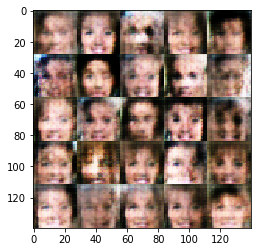

Epoch 1/1... Batch 910... Discriminator Loss: 0.9892... Generator Loss: 0.6987 Total Loss: 1.6878
Epoch 1/1... Batch 920... Discriminator Loss: 0.7857... Generator Loss: 2.1217 Total Loss: 2.9074
Epoch 1/1... Batch 930... Discriminator Loss: 1.0155... Generator Loss: 1.7801 Total Loss: 2.7957
Epoch 1/1... Batch 940... Discriminator Loss: 0.7291... Generator Loss: 1.6200 Total Loss: 2.3491
Epoch 1/1... Batch 950... Discriminator Loss: 1.1041... Generator Loss: 0.6043 Total Loss: 1.7084
Epoch 1/1... Batch 960... Discriminator Loss: 0.8283... Generator Loss: 1.0070 Total Loss: 1.8354
Epoch 1/1... Batch 970... Discriminator Loss: 0.8025... Generator Loss: 1.1110 Total Loss: 1.9135
Epoch 1/1... Batch 980... Discriminator Loss: 0.9090... Generator Loss: 0.9490 Total Loss: 1.8580
Epoch 1/1... Batch 990... Discriminator Loss: 0.9840... Generator Loss: 0.9126 Total Loss: 1.8967
Epoch 1/1... Batch 1000... Discriminator Loss: 0.6883... Generator Loss: 1.8765 Total Loss: 2.5648


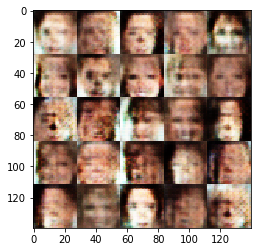

Epoch 1/1... Batch 1010... Discriminator Loss: 0.7224... Generator Loss: 1.9069 Total Loss: 2.6293
Epoch 1/1... Batch 1020... Discriminator Loss: 0.9779... Generator Loss: 0.7939 Total Loss: 1.7717
Epoch 1/1... Batch 1030... Discriminator Loss: 0.9735... Generator Loss: 1.4047 Total Loss: 2.3783
Epoch 1/1... Batch 1040... Discriminator Loss: 0.8262... Generator Loss: 1.3399 Total Loss: 2.1662
Epoch 1/1... Batch 1050... Discriminator Loss: 0.7608... Generator Loss: 1.3464 Total Loss: 2.1072
Epoch 1/1... Batch 1060... Discriminator Loss: 0.7247... Generator Loss: 1.0779 Total Loss: 1.8026
Epoch 1/1... Batch 1070... Discriminator Loss: 0.9147... Generator Loss: 1.0383 Total Loss: 1.9530
Epoch 1/1... Batch 1080... Discriminator Loss: 0.9082... Generator Loss: 1.1117 Total Loss: 2.0199
Epoch 1/1... Batch 1090... Discriminator Loss: 0.8327... Generator Loss: 1.4895 Total Loss: 2.3223
Epoch 1/1... Batch 1100... Discriminator Loss: 1.4638... Generator Loss: 0.4109 Total Loss: 1.8747


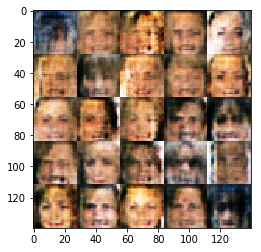

Epoch 1/1... Batch 1110... Discriminator Loss: 1.0030... Generator Loss: 0.7522 Total Loss: 1.7553
Epoch 1/1... Batch 1120... Discriminator Loss: 0.8501... Generator Loss: 1.9924 Total Loss: 2.8424
Epoch 1/1... Batch 1130... Discriminator Loss: 0.9265... Generator Loss: 0.8988 Total Loss: 1.8253
Epoch 1/1... Batch 1140... Discriminator Loss: 0.9028... Generator Loss: 1.1546 Total Loss: 2.0574
Epoch 1/1... Batch 1150... Discriminator Loss: 0.8364... Generator Loss: 1.3887 Total Loss: 2.2251
Epoch 1/1... Batch 1160... Discriminator Loss: 1.0168... Generator Loss: 2.2364 Total Loss: 3.2532
Epoch 1/1... Batch 1170... Discriminator Loss: 0.8456... Generator Loss: 0.9234 Total Loss: 1.7690
Epoch 1/1... Batch 1180... Discriminator Loss: 1.0340... Generator Loss: 0.8612 Total Loss: 1.8951
Epoch 1/1... Batch 1190... Discriminator Loss: 1.1710... Generator Loss: 0.5879 Total Loss: 1.7589
Epoch 1/1... Batch 1200... Discriminator Loss: 0.7293... Generator Loss: 1.7464 Total Loss: 2.4757


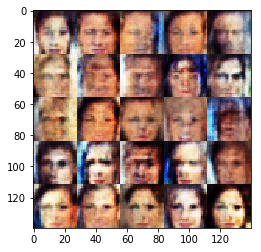

Epoch 1/1... Batch 1210... Discriminator Loss: 0.9315... Generator Loss: 1.3148 Total Loss: 2.2464
Epoch 1/1... Batch 1220... Discriminator Loss: 1.0833... Generator Loss: 0.6308 Total Loss: 1.7141
Epoch 1/1... Batch 1230... Discriminator Loss: 0.8689... Generator Loss: 1.4254 Total Loss: 2.2943
Epoch 1/1... Batch 1240... Discriminator Loss: 1.0345... Generator Loss: 0.7871 Total Loss: 1.8216
Epoch 1/1... Batch 1250... Discriminator Loss: 0.9085... Generator Loss: 0.9618 Total Loss: 1.8703
Epoch 1/1... Batch 1260... Discriminator Loss: 1.0562... Generator Loss: 0.9307 Total Loss: 1.9870
Epoch 1/1... Batch 1270... Discriminator Loss: 0.9237... Generator Loss: 1.0609 Total Loss: 1.9846
Epoch 1/1... Batch 1280... Discriminator Loss: 0.9290... Generator Loss: 0.8665 Total Loss: 1.7956
Epoch 1/1... Batch 1290... Discriminator Loss: 0.7205... Generator Loss: 1.6780 Total Loss: 2.3985
Epoch 1/1... Batch 1300... Discriminator Loss: 0.6719... Generator Loss: 1.3647 Total Loss: 2.0366


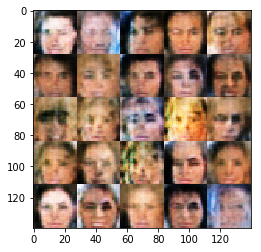

Epoch 1/1... Batch 1310... Discriminator Loss: 0.8417... Generator Loss: 1.2480 Total Loss: 2.0898
Epoch 1/1... Batch 1320... Discriminator Loss: 1.0607... Generator Loss: 0.7244 Total Loss: 1.7852
Epoch 1/1... Batch 1330... Discriminator Loss: 0.9306... Generator Loss: 1.2509 Total Loss: 2.1816
Epoch 1/1... Batch 1340... Discriminator Loss: 0.9329... Generator Loss: 0.9675 Total Loss: 1.9004
Epoch 1/1... Batch 1350... Discriminator Loss: 0.9935... Generator Loss: 0.8668 Total Loss: 1.8603
Epoch 1/1... Batch 1360... Discriminator Loss: 0.9189... Generator Loss: 2.0619 Total Loss: 2.9808
Epoch 1/1... Batch 1370... Discriminator Loss: 1.3209... Generator Loss: 0.5029 Total Loss: 1.8237
Epoch 1/1... Batch 1380... Discriminator Loss: 1.1490... Generator Loss: 0.6674 Total Loss: 1.8163
Epoch 1/1... Batch 1390... Discriminator Loss: 0.8446... Generator Loss: 1.6446 Total Loss: 2.4892
Epoch 1/1... Batch 1400... Discriminator Loss: 0.8064... Generator Loss: 1.1035 Total Loss: 1.9099


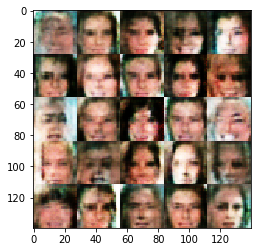

Epoch 1/1... Batch 1410... Discriminator Loss: 0.9547... Generator Loss: 1.2074 Total Loss: 2.1621
Epoch 1/1... Batch 1420... Discriminator Loss: 1.0361... Generator Loss: 0.7539 Total Loss: 1.7900
Epoch 1/1... Batch 1430... Discriminator Loss: 1.2513... Generator Loss: 0.6477 Total Loss: 1.8990
Epoch 1/1... Batch 1440... Discriminator Loss: 1.0180... Generator Loss: 1.8485 Total Loss: 2.8665
Epoch 1/1... Batch 1450... Discriminator Loss: 0.8600... Generator Loss: 1.0577 Total Loss: 1.9176
Epoch 1/1... Batch 1460... Discriminator Loss: 1.1562... Generator Loss: 2.2301 Total Loss: 3.3863
Epoch 1/1... Batch 1470... Discriminator Loss: 1.0916... Generator Loss: 1.7720 Total Loss: 2.8636
Epoch 1/1... Batch 1480... Discriminator Loss: 0.9392... Generator Loss: 1.1744 Total Loss: 2.1136
Epoch 1/1... Batch 1490... Discriminator Loss: 0.8424... Generator Loss: 1.2942 Total Loss: 2.1366
Epoch 1/1... Batch 1500... Discriminator Loss: 0.9140... Generator Loss: 1.0752 Total Loss: 1.9893


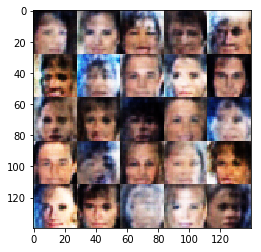

Epoch 1/1... Batch 1510... Discriminator Loss: 1.1802... Generator Loss: 0.6207 Total Loss: 1.8009
Epoch 1/1... Batch 1520... Discriminator Loss: 0.8981... Generator Loss: 1.2032 Total Loss: 2.1013
Epoch 1/1... Batch 1530... Discriminator Loss: 1.0480... Generator Loss: 1.0182 Total Loss: 2.0662
Epoch 1/1... Batch 1540... Discriminator Loss: 0.9796... Generator Loss: 1.2106 Total Loss: 2.1902
Epoch 1/1... Batch 1550... Discriminator Loss: 0.9959... Generator Loss: 0.9265 Total Loss: 1.9224
Epoch 1/1... Batch 1560... Discriminator Loss: 0.8632... Generator Loss: 1.0589 Total Loss: 1.9221
Epoch 1/1... Batch 1570... Discriminator Loss: 0.8844... Generator Loss: 1.1797 Total Loss: 2.0641
Epoch 1/1... Batch 1580... Discriminator Loss: 0.8871... Generator Loss: 1.0972 Total Loss: 1.9843
Epoch 1/1... Batch 1590... Discriminator Loss: 0.9520... Generator Loss: 1.2729 Total Loss: 2.2249
Epoch 1/1... Batch 1600... Discriminator Loss: 0.9969... Generator Loss: 0.7847 Total Loss: 1.7817


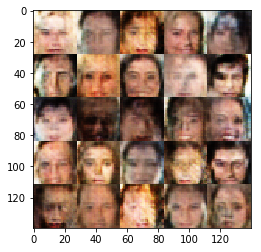

Epoch 1/1... Batch 1610... Discriminator Loss: 0.8868... Generator Loss: 1.0620 Total Loss: 1.9488
Epoch 1/1... Batch 1620... Discriminator Loss: 1.1884... Generator Loss: 1.9448 Total Loss: 3.1331
Epoch 1/1... Batch 1630... Discriminator Loss: 1.0610... Generator Loss: 0.7927 Total Loss: 1.8536
Epoch 1/1... Batch 1640... Discriminator Loss: 0.9982... Generator Loss: 0.9584 Total Loss: 1.9566
Epoch 1/1... Batch 1650... Discriminator Loss: 0.9506... Generator Loss: 1.2676 Total Loss: 2.2182
Epoch 1/1... Batch 1660... Discriminator Loss: 1.4047... Generator Loss: 0.4242 Total Loss: 1.8290
Epoch 1/1... Batch 1670... Discriminator Loss: 0.8371... Generator Loss: 1.1826 Total Loss: 2.0197
Epoch 1/1... Batch 1680... Discriminator Loss: 0.8972... Generator Loss: 1.1587 Total Loss: 2.0559
Epoch 1/1... Batch 1690... Discriminator Loss: 1.1422... Generator Loss: 0.7181 Total Loss: 1.8603
Epoch 1/1... Batch 1700... Discriminator Loss: 0.8725... Generator Loss: 1.1836 Total Loss: 2.0561


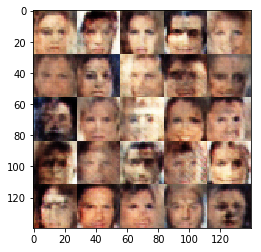

Epoch 1/1... Batch 1710... Discriminator Loss: 0.9555... Generator Loss: 0.8717 Total Loss: 1.8272
Epoch 1/1... Batch 1720... Discriminator Loss: 0.9428... Generator Loss: 0.9374 Total Loss: 1.8802
Epoch 1/1... Batch 1730... Discriminator Loss: 1.0292... Generator Loss: 1.0131 Total Loss: 2.0423
Epoch 1/1... Batch 1740... Discriminator Loss: 0.9364... Generator Loss: 1.0821 Total Loss: 2.0185
Epoch 1/1... Batch 1750... Discriminator Loss: 0.8899... Generator Loss: 1.1481 Total Loss: 2.0380
Epoch 1/1... Batch 1760... Discriminator Loss: 0.9206... Generator Loss: 0.9741 Total Loss: 1.8947
Epoch 1/1... Batch 1770... Discriminator Loss: 1.0689... Generator Loss: 1.7836 Total Loss: 2.8525
Epoch 1/1... Batch 1780... Discriminator Loss: 1.1246... Generator Loss: 0.5808 Total Loss: 1.7054
Epoch 1/1... Batch 1790... Discriminator Loss: 1.5477... Generator Loss: 0.3602 Total Loss: 1.9080
Epoch 1/1... Batch 1800... Discriminator Loss: 1.0732... Generator Loss: 0.8866 Total Loss: 1.9599


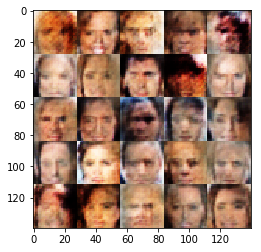

Epoch 1/1... Batch 1810... Discriminator Loss: 1.0996... Generator Loss: 1.8074 Total Loss: 2.9070
Epoch 1/1... Batch 1820... Discriminator Loss: 0.9374... Generator Loss: 1.1486 Total Loss: 2.0860
Epoch 1/1... Batch 1830... Discriminator Loss: 1.5131... Generator Loss: 1.9102 Total Loss: 3.4233
Epoch 1/1... Batch 1840... Discriminator Loss: 1.1146... Generator Loss: 1.5980 Total Loss: 2.7127
Epoch 1/1... Batch 1850... Discriminator Loss: 0.9396... Generator Loss: 0.9835 Total Loss: 1.9231
Epoch 1/1... Batch 1860... Discriminator Loss: 0.8806... Generator Loss: 1.1104 Total Loss: 1.9909
Epoch 1/1... Batch 1870... Discriminator Loss: 2.0317... Generator Loss: 0.2302 Total Loss: 2.2619
Epoch 1/1... Batch 1880... Discriminator Loss: 0.9309... Generator Loss: 1.0613 Total Loss: 1.9922
Epoch 1/1... Batch 1890... Discriminator Loss: 0.9933... Generator Loss: 0.8851 Total Loss: 1.8784
Epoch 1/1... Batch 1900... Discriminator Loss: 0.9460... Generator Loss: 1.2899 Total Loss: 2.2360


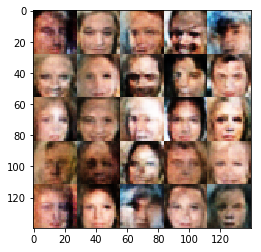

Epoch 1/1... Batch 1910... Discriminator Loss: 1.0351... Generator Loss: 0.7265 Total Loss: 1.7616
Epoch 1/1... Batch 1920... Discriminator Loss: 1.0791... Generator Loss: 0.6929 Total Loss: 1.7720
Epoch 1/1... Batch 1930... Discriminator Loss: 1.0089... Generator Loss: 0.7954 Total Loss: 1.8043
Epoch 1/1... Batch 1940... Discriminator Loss: 1.0255... Generator Loss: 1.1219 Total Loss: 2.1474
Epoch 1/1... Batch 1950... Discriminator Loss: 1.1517... Generator Loss: 0.7763 Total Loss: 1.9279
Epoch 1/1... Batch 1960... Discriminator Loss: 0.9208... Generator Loss: 0.9886 Total Loss: 1.9095
Epoch 1/1... Batch 1970... Discriminator Loss: 1.0445... Generator Loss: 0.6812 Total Loss: 1.7257
Epoch 1/1... Batch 1980... Discriminator Loss: 0.9878... Generator Loss: 0.9592 Total Loss: 1.9470
Epoch 1/1... Batch 1990... Discriminator Loss: 1.2444... Generator Loss: 1.9114 Total Loss: 3.1557
Epoch 1/1... Batch 2000... Discriminator Loss: 1.0458... Generator Loss: 1.3920 Total Loss: 2.4378


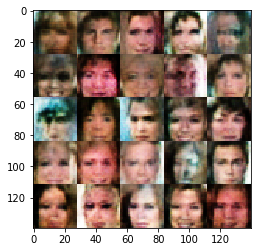

Epoch 1/1... Batch 2010... Discriminator Loss: 1.0913... Generator Loss: 0.6749 Total Loss: 1.7662
Epoch 1/1... Batch 2020... Discriminator Loss: 0.8710... Generator Loss: 1.3702 Total Loss: 2.2412
Epoch 1/1... Batch 2030... Discriminator Loss: 1.0989... Generator Loss: 0.6703 Total Loss: 1.7693
Epoch 1/1... Batch 2040... Discriminator Loss: 1.0971... Generator Loss: 0.7177 Total Loss: 1.8148
Epoch 1/1... Batch 2050... Discriminator Loss: 0.9879... Generator Loss: 0.9749 Total Loss: 1.9628
Epoch 1/1... Batch 2060... Discriminator Loss: 1.0860... Generator Loss: 0.7537 Total Loss: 1.8397
Epoch 1/1... Batch 2070... Discriminator Loss: 1.1050... Generator Loss: 0.6913 Total Loss: 1.7963
Epoch 1/1... Batch 2080... Discriminator Loss: 1.0080... Generator Loss: 1.1083 Total Loss: 2.1164
Epoch 1/1... Batch 2090... Discriminator Loss: 0.9316... Generator Loss: 1.0265 Total Loss: 1.9581
Epoch 1/1... Batch 2100... Discriminator Loss: 0.9435... Generator Loss: 0.7759 Total Loss: 1.7194


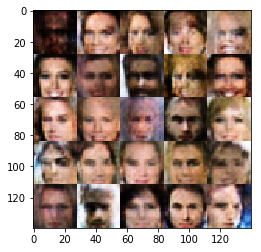

Epoch 1/1... Batch 2110... Discriminator Loss: 1.0801... Generator Loss: 0.8142 Total Loss: 1.8942
Epoch 1/1... Batch 2120... Discriminator Loss: 1.1511... Generator Loss: 0.8397 Total Loss: 1.9909
Epoch 1/1... Batch 2130... Discriminator Loss: 1.0097... Generator Loss: 0.8250 Total Loss: 1.8347
Epoch 1/1... Batch 2140... Discriminator Loss: 0.8795... Generator Loss: 1.2616 Total Loss: 2.1411
Epoch 1/1... Batch 2150... Discriminator Loss: 1.0223... Generator Loss: 0.8577 Total Loss: 1.8800
Epoch 1/1... Batch 2160... Discriminator Loss: 1.1152... Generator Loss: 0.6623 Total Loss: 1.7775
Epoch 1/1... Batch 2170... Discriminator Loss: 1.2189... Generator Loss: 1.7506 Total Loss: 2.9694
Epoch 1/1... Batch 2180... Discriminator Loss: 1.1322... Generator Loss: 0.7405 Total Loss: 1.8727
Epoch 1/1... Batch 2190... Discriminator Loss: 1.2870... Generator Loss: 0.5501 Total Loss: 1.8371
Epoch 1/1... Batch 2200... Discriminator Loss: 1.1064... Generator Loss: 0.6366 Total Loss: 1.7430


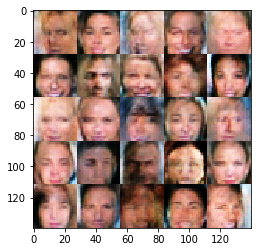

Epoch 1/1... Batch 2210... Discriminator Loss: 1.0382... Generator Loss: 1.3754 Total Loss: 2.4136
Epoch 1/1... Batch 2220... Discriminator Loss: 0.9568... Generator Loss: 0.9626 Total Loss: 1.9194
Epoch 1/1... Batch 2230... Discriminator Loss: 1.1658... Generator Loss: 1.2415 Total Loss: 2.4073
Epoch 1/1... Batch 2240... Discriminator Loss: 0.9174... Generator Loss: 1.0471 Total Loss: 1.9645
Epoch 1/1... Batch 2250... Discriminator Loss: 0.9892... Generator Loss: 0.7716 Total Loss: 1.7608
Epoch 1/1... Batch 2260... Discriminator Loss: 1.0558... Generator Loss: 0.7520 Total Loss: 1.8079
Epoch 1/1... Batch 2270... Discriminator Loss: 0.9999... Generator Loss: 0.8397 Total Loss: 1.8396
Epoch 1/1... Batch 2280... Discriminator Loss: 0.9299... Generator Loss: 1.0171 Total Loss: 1.9469
Epoch 1/1... Batch 2290... Discriminator Loss: 0.9775... Generator Loss: 0.8793 Total Loss: 1.8568
Epoch 1/1... Batch 2300... Discriminator Loss: 1.0378... Generator Loss: 1.6221 Total Loss: 2.6598


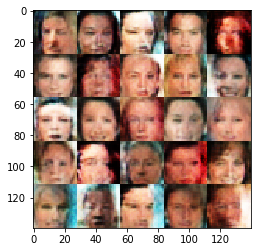

Epoch 1/1... Batch 2310... Discriminator Loss: 1.0503... Generator Loss: 1.4235 Total Loss: 2.4738
Epoch 1/1... Batch 2320... Discriminator Loss: 1.0007... Generator Loss: 1.4723 Total Loss: 2.4730
Epoch 1/1... Batch 2330... Discriminator Loss: 0.9902... Generator Loss: 1.6804 Total Loss: 2.6706
Epoch 1/1... Batch 2340... Discriminator Loss: 0.9308... Generator Loss: 1.1301 Total Loss: 2.0609
Epoch 1/1... Batch 2350... Discriminator Loss: 1.1466... Generator Loss: 0.7096 Total Loss: 1.8563
Epoch 1/1... Batch 2360... Discriminator Loss: 1.1210... Generator Loss: 0.7029 Total Loss: 1.8238
Epoch 1/1... Batch 2370... Discriminator Loss: 1.1563... Generator Loss: 0.6481 Total Loss: 1.8044
Epoch 1/1... Batch 2380... Discriminator Loss: 1.1301... Generator Loss: 0.6618 Total Loss: 1.7920
Epoch 1/1... Batch 2390... Discriminator Loss: 1.1767... Generator Loss: 0.5633 Total Loss: 1.7400
Epoch 1/1... Batch 2400... Discriminator Loss: 0.9206... Generator Loss: 0.9249 Total Loss: 1.8455


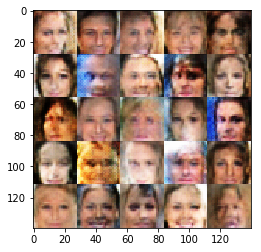

Epoch 1/1... Batch 2410... Discriminator Loss: 1.2384... Generator Loss: 1.3987 Total Loss: 2.6371
Epoch 1/1... Batch 2420... Discriminator Loss: 0.9860... Generator Loss: 1.3501 Total Loss: 2.3361
Epoch 1/1... Batch 2430... Discriminator Loss: 0.9158... Generator Loss: 1.1735 Total Loss: 2.0893
Epoch 1/1... Batch 2440... Discriminator Loss: 0.9387... Generator Loss: 1.0804 Total Loss: 2.0191
Epoch 1/1... Batch 2450... Discriminator Loss: 0.9378... Generator Loss: 1.0161 Total Loss: 1.9540
Epoch 1/1... Batch 2460... Discriminator Loss: 1.1438... Generator Loss: 0.7000 Total Loss: 1.8438
Epoch 1/1... Batch 2470... Discriminator Loss: 0.9331... Generator Loss: 0.9952 Total Loss: 1.9284
Epoch 1/1... Batch 2480... Discriminator Loss: 1.2248... Generator Loss: 1.4358 Total Loss: 2.6606
Epoch 1/1... Batch 2490... Discriminator Loss: 1.0052... Generator Loss: 1.1237 Total Loss: 2.1289
Epoch 1/1... Batch 2500... Discriminator Loss: 0.8928... Generator Loss: 0.9819 Total Loss: 1.8747


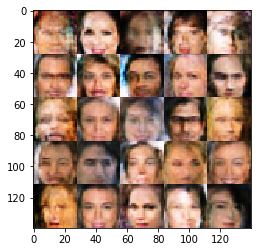

Epoch 1/1... Batch 2510... Discriminator Loss: 0.9133... Generator Loss: 1.6892 Total Loss: 2.6025
Epoch 1/1... Batch 2520... Discriminator Loss: 1.0207... Generator Loss: 1.0716 Total Loss: 2.0922
Epoch 1/1... Batch 2530... Discriminator Loss: 1.0540... Generator Loss: 1.4823 Total Loss: 2.5363
Epoch 1/1... Batch 2540... Discriminator Loss: 1.0476... Generator Loss: 0.8130 Total Loss: 1.8606
Epoch 1/1... Batch 2550... Discriminator Loss: 1.1410... Generator Loss: 1.2952 Total Loss: 2.4362
Epoch 1/1... Batch 2560... Discriminator Loss: 1.1445... Generator Loss: 1.3069 Total Loss: 2.4514
Epoch 1/1... Batch 2570... Discriminator Loss: 1.0900... Generator Loss: 1.2042 Total Loss: 2.2941
Epoch 1/1... Batch 2580... Discriminator Loss: 1.0031... Generator Loss: 0.7635 Total Loss: 1.7666
Epoch 1/1... Batch 2590... Discriminator Loss: 1.1556... Generator Loss: 1.4212 Total Loss: 2.5768
Epoch 1/1... Batch 2600... Discriminator Loss: 1.2410... Generator Loss: 0.5984 Total Loss: 1.8394


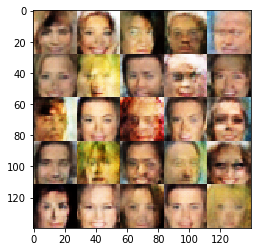

Epoch 1/1... Batch 2610... Discriminator Loss: 0.9715... Generator Loss: 0.9595 Total Loss: 1.9310
Epoch 1/1... Batch 2620... Discriminator Loss: 1.0043... Generator Loss: 0.8870 Total Loss: 1.8913
Epoch 1/1... Batch 2630... Discriminator Loss: 1.0733... Generator Loss: 0.8530 Total Loss: 1.9264
Epoch 1/1... Batch 2640... Discriminator Loss: 1.0011... Generator Loss: 1.0666 Total Loss: 2.0677
Epoch 1/1... Batch 2650... Discriminator Loss: 1.1943... Generator Loss: 1.5954 Total Loss: 2.7897
Epoch 1/1... Batch 2660... Discriminator Loss: 1.0184... Generator Loss: 1.3557 Total Loss: 2.3741
Epoch 1/1... Batch 2670... Discriminator Loss: 1.1500... Generator Loss: 1.1884 Total Loss: 2.3383
Epoch 1/1... Batch 2680... Discriminator Loss: 1.1005... Generator Loss: 1.0843 Total Loss: 2.1848
Epoch 1/1... Batch 2690... Discriminator Loss: 1.0262... Generator Loss: 0.7892 Total Loss: 1.8154
Epoch 1/1... Batch 2700... Discriminator Loss: 0.9818... Generator Loss: 1.0099 Total Loss: 1.9916


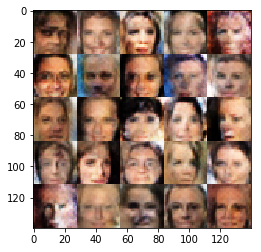

Epoch 1/1... Batch 2710... Discriminator Loss: 1.0178... Generator Loss: 0.8225 Total Loss: 1.8403
Epoch 1/1... Batch 2720... Discriminator Loss: 1.0132... Generator Loss: 0.7984 Total Loss: 1.8116
Epoch 1/1... Batch 2730... Discriminator Loss: 1.2821... Generator Loss: 0.5204 Total Loss: 1.8025
Epoch 1/1... Batch 2740... Discriminator Loss: 0.9956... Generator Loss: 1.5714 Total Loss: 2.5669
Epoch 1/1... Batch 2750... Discriminator Loss: 1.1690... Generator Loss: 0.6312 Total Loss: 1.8002
Epoch 1/1... Batch 2760... Discriminator Loss: 0.9871... Generator Loss: 1.1315 Total Loss: 2.1186
Epoch 1/1... Batch 2770... Discriminator Loss: 1.0097... Generator Loss: 0.8992 Total Loss: 1.9090
Epoch 1/1... Batch 2780... Discriminator Loss: 1.0937... Generator Loss: 0.7147 Total Loss: 1.8084
Epoch 1/1... Batch 2790... Discriminator Loss: 1.7638... Generator Loss: 2.3306 Total Loss: 4.0944
Epoch 1/1... Batch 2800... Discriminator Loss: 1.2025... Generator Loss: 0.6392 Total Loss: 1.8416


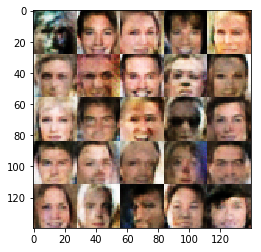

Epoch 1/1... Batch 2810... Discriminator Loss: 1.1419... Generator Loss: 0.7442 Total Loss: 1.8861
Epoch 1/1... Batch 2820... Discriminator Loss: 1.2830... Generator Loss: 0.5410 Total Loss: 1.8240
Epoch 1/1... Batch 2830... Discriminator Loss: 0.9672... Generator Loss: 1.0442 Total Loss: 2.0115
Epoch 1/1... Batch 2840... Discriminator Loss: 1.0421... Generator Loss: 1.0942 Total Loss: 2.1363
Epoch 1/1... Batch 2850... Discriminator Loss: 1.1242... Generator Loss: 1.6663 Total Loss: 2.7905
Epoch 1/1... Batch 2860... Discriminator Loss: 1.0894... Generator Loss: 0.7320 Total Loss: 1.8215
Epoch 1/1... Batch 2870... Discriminator Loss: 1.0682... Generator Loss: 0.6679 Total Loss: 1.7361
Epoch 1/1... Batch 2880... Discriminator Loss: 0.9142... Generator Loss: 1.1199 Total Loss: 2.0341
Epoch 1/1... Batch 2890... Discriminator Loss: 0.9450... Generator Loss: 1.1847 Total Loss: 2.1298
Epoch 1/1... Batch 2900... Discriminator Loss: 1.2495... Generator Loss: 1.6023 Total Loss: 2.8518


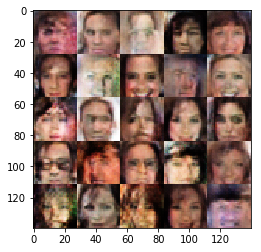

Epoch 1/1... Batch 2910... Discriminator Loss: 0.9941... Generator Loss: 0.9325 Total Loss: 1.9266
Epoch 1/1... Batch 2920... Discriminator Loss: 1.1419... Generator Loss: 1.4877 Total Loss: 2.6296
Epoch 1/1... Batch 2930... Discriminator Loss: 0.8829... Generator Loss: 1.0218 Total Loss: 1.9046
Epoch 1/1... Batch 2940... Discriminator Loss: 1.2098... Generator Loss: 0.6450 Total Loss: 1.8548
Epoch 1/1... Batch 2950... Discriminator Loss: 1.0604... Generator Loss: 0.9898 Total Loss: 2.0502
Epoch 1/1... Batch 2960... Discriminator Loss: 1.0507... Generator Loss: 1.0057 Total Loss: 2.0564
Epoch 1/1... Batch 2970... Discriminator Loss: 1.0358... Generator Loss: 1.2390 Total Loss: 2.2747
Epoch 1/1... Batch 2980... Discriminator Loss: 1.3132... Generator Loss: 0.4791 Total Loss: 1.7923
Epoch 1/1... Batch 2990... Discriminator Loss: 1.1295... Generator Loss: 0.7546 Total Loss: 1.8842
Epoch 1/1... Batch 3000... Discriminator Loss: 1.1106... Generator Loss: 0.8456 Total Loss: 1.9562


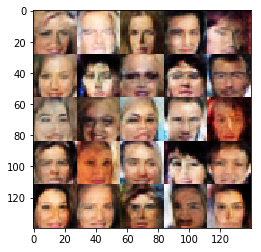

Epoch 1/1... Batch 3010... Discriminator Loss: 0.9728... Generator Loss: 1.1793 Total Loss: 2.1521
Epoch 1/1... Batch 3020... Discriminator Loss: 0.9850... Generator Loss: 0.9521 Total Loss: 1.9371
Epoch 1/1... Batch 3030... Discriminator Loss: 1.0288... Generator Loss: 0.8298 Total Loss: 1.8586
Epoch 1/1... Batch 3040... Discriminator Loss: 1.2454... Generator Loss: 1.1912 Total Loss: 2.4366
Epoch 1/1... Batch 3050... Discriminator Loss: 0.9395... Generator Loss: 1.1000 Total Loss: 2.0395
Epoch 1/1... Batch 3060... Discriminator Loss: 1.0681... Generator Loss: 0.7393 Total Loss: 1.8073
Epoch 1/1... Batch 3070... Discriminator Loss: 1.1519... Generator Loss: 0.5709 Total Loss: 1.7229
Epoch 1/1... Batch 3080... Discriminator Loss: 0.8023... Generator Loss: 1.2788 Total Loss: 2.0811
Epoch 1/1... Batch 3090... Discriminator Loss: 1.0681... Generator Loss: 0.8184 Total Loss: 1.8865
Epoch 1/1... Batch 3100... Discriminator Loss: 1.0220... Generator Loss: 0.7831 Total Loss: 1.8052


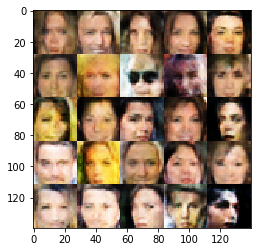

Epoch 1/1... Batch 3110... Discriminator Loss: 1.2195... Generator Loss: 0.6042 Total Loss: 1.8237
Epoch 1/1... Batch 3120... Discriminator Loss: 1.0911... Generator Loss: 0.6883 Total Loss: 1.7794
Epoch 1/1... Batch 3130... Discriminator Loss: 0.9618... Generator Loss: 1.2356 Total Loss: 2.1974
Epoch 1/1... Batch 3140... Discriminator Loss: 1.0303... Generator Loss: 1.4531 Total Loss: 2.4834
Epoch 1/1... Batch 3150... Discriminator Loss: 1.0933... Generator Loss: 0.7674 Total Loss: 1.8608
Epoch 1/1... Batch 3160... Discriminator Loss: 1.2531... Generator Loss: 0.5529 Total Loss: 1.8060


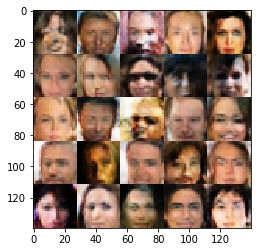

In [17]:
#batch_size = 64
#z_dim = 128
#lr = 0.0001
#beta1 = 0.5

batch_size = 64
z_dim = 100
lr = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, lr, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.

In [ ]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
                
                